# Continued from proj3_part1

### Data Cleaning and EDA

## 1. Import relevant libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import re
import shap
import redditcleaner
import demoji
import emot
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import spacy
import warnings
warnings.filterwarnings('ignore')
nlp = spacy.load("en_core_web_sm")

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, LogisticRegression, ElasticNetCV
from sklearn.model_selection import train_test_split, cross_val_score, KFold, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier

from catboost import CatBoostClassifier, Pool
from sklearn import model_selection
from sklearn.metrics import mean_squared_error, plot_roc_curve
from sklearn.preprocessing import LabelEncoder

%matplotlib inline

spaCy was used over NLTK for much of the NLP processing as it provides advanced NLP techniques vs NLTK.

In [2]:
np.random.seed(42)

## Writing custom functions to remove

1. removed/deleted posts
2. links urls
3. punctuations
4. Non-ascii characters
5. using redditcleaner to clean markdown formatting

##### Writing function to remove emoji from text

In [3]:
def remove_emoji(text):
    demoj = demoji.findall(text)
    for i in demoj.keys():
        text = text.replace(i, np.nan)
        text = re.sub([b], "", text)
    return text

##### Function to remove non ascii characters

In [4]:
def enc(text):
    text = text.encode('ascii',errors='ignore').decode()
    return text

##### Function to remove punctuations

In [5]:
def punc(text):
    text = re.sub("[^\w\s]", "", text)
    return text

##### Using redditcleaner to remove reddit markdown formatting

From redditcleaner API:

"the raw comment bodies or submission self texts may look like this:

Normal text\n\n**Bold**\n\n*Italic*\n\n[Link](https://fsf.org)\n\n
~~Strike-through~~\n\n`Code`\n\n^(Superscript)
\n\n&gt;!Spoiler!&lt;\n\n# Heading\n\nBullet list:\n\n* Item 1\n* Item 2
\n\nNumbered list:\n\n1. Item 1\n2. Item 2\n\n&gt;Quote\n\n 
Code block\n\nTable:\n\n|Cell 1.1|Cell 1.2|\n|:-|:-|\n|Cell 2.1|Cell 2.2|

\n * Find &amp;#x200B; &gt; "\&gt; the "&gt; hidden\ntext [fsf](http://fsf.org)...
This & that in a normal sentence. "manual quote"
These characters stem from (Reddit-specific) Markdown formatting."

Source:
https://github.com/LoLei/redditcleaner

Hence, redditcleaner API will be imported and be used to clean the scraped posts.

In [6]:
def removed_posts(text):
    text = re.sub(r'\[[^()]*\]', "", text)
    return text

##### Writing function to remove links

In [7]:
def clean_links(text):
    text = re.sub(r'http\S+', "", text)
    return text

## 2. Read data from Aliens Posts

In [8]:
aliens_posts = pd.read_csv('./datasets/aliens_posts.csv')

In [9]:
aliens_posts.shape

(10000, 3)

In [10]:
aliens_posts.head(3)

,subreddit,selftext,title
0,aliens,Does anyone know what their bodies are like on...,What do we know about the greys' anatomy?
1,aliens,NaN,Grey in Northern Connecticut
2,aliens,NaN,"Look in the top left, has nick Pope said anyth..."


## 3. Read data from Space Posts

In [11]:
space_posts = pd.read_csv('./datasets/space_posts.csv')

In [12]:
space_posts.shape

(10000, 3)

In [13]:
space_posts.head(3)

,subreddit,selftext,title
0,space,NaN,Caught a 22° halo (moon ring) tonight! With Ma...
1,space,NaN,"Having dinner at a UFO in Roswell, NM"
2,space,NaN,Harvest Moon and Mars this evening


## Feature Engineering for reddit posts

### Feature Engineering

1. "selftext" will be replaced with concatenated "title" & "selftext"
2. A new column containing the word count of the post called "post_length" will be created

# Aliens

In [14]:
aliens_posts['selftext'] = aliens_posts['title'] + " " + aliens_posts['selftext']

In [15]:
aliens_posts['post_length'] = aliens_posts['selftext'].str.len()

In [16]:
aliens_posts.head(3)

,subreddit,selftext,title,post_length
0,aliens,What do we know about the greys' anatomy? Does...,What do we know about the greys' anatomy?,126.0
1,aliens,NaN,Grey in Northern Connecticut,NaN
2,aliens,NaN,"Look in the top left, has nick Pope said anyth...",NaN


### Drop NA

In [17]:
aliens_posts.isna().sum()

subreddit         0
selftext       5790
title             0
post_length    5790
dtype: int64

In [18]:
aliens_posts = aliens_posts.dropna(axis=0, how='any')

In [19]:
aliens_posts.shape

(4210, 4)

In [20]:
aliens_posts = aliens_posts[['subreddit', 'selftext', 'post_length']]

In [21]:
aliens_posts.head(3)

,subreddit,selftext,post_length
0,aliens,What do we know about the greys' anatomy? Does...,126.0
3,aliens,Help finding a video A video got posted on thi...,122.0
4,aliens,Exonews.org? I just found this site and it see...,174.0


# Space

In [22]:
space_posts['selftext'] = space_posts['title'] + " " + space_posts['selftext']

In [23]:
space_posts['post_length'] = space_posts['selftext'].str.len()

In [24]:
space_posts.head(3)

,subreddit,selftext,title,post_length
0,space,NaN,Caught a 22° halo (moon ring) tonight! With Ma...,NaN
1,space,NaN,"Having dinner at a UFO in Roswell, NM",NaN
2,space,NaN,Harvest Moon and Mars this evening,NaN


In [25]:
space_posts = space_posts.dropna(axis=0, how='any')

In [26]:
space_posts.shape

(2361, 4)

In [27]:
space_posts = space_posts[['subreddit', 'selftext', 'post_length']]

In [28]:
space_posts.head(3)

,subreddit,selftext,post_length
10,space,Can someone ban me I am tired of getting this ...,82.0
15,space,Hey — I love space... again. Hi everyone. When...,332.0
16,space,something bright i was looking east at about 7...,512.0


## Data Cleaning for Space and Aliens subreddit

## Framing data cleaning and EDA steps
### Handling missing data & cleaning

1. Keep "subreddit", "title", "selftext" in dataframes.

2. Missing values such as "[Removed]" or "[Deleted]" will be substituted with empty string and dropped.

3. Text will be converted to lower case

4. Non-ASCII characters will be substituted with empty strings

5. Punctuations will be removed

6. Reddit-specific markdown formatting will be substituted with empty strings

7. Links and URLs will be substituted with empty strings and removed

8. Duplicate rows will be identified and removed

9. Output descriptive statistics, distributions, identify and remove outliers

10. Append "Aliens" and "Space" dataframes

## Examining and Describing Distributions

# Aliens

In [29]:
aliens_posts['post_length'].describe()

count     4210.000000
mean       825.682898
std       1813.918109
min          3.000000
25%        115.250000
50%        328.000000
75%        856.000000
max      37336.000000
Name: post_length, dtype: float64

### VIsualizing distributions

#### Before dropping outliers

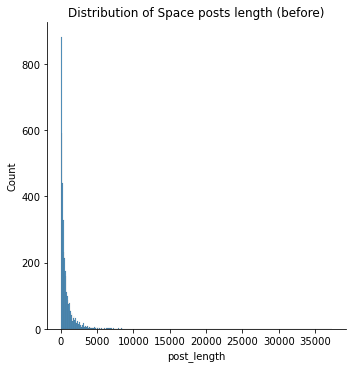

In [30]:
sns.displot(aliens_posts['post_length']).set(title='Distribution of Space posts length (before)');

There are abnormally large outliers in the word count which will be removed.

#### Making use of Median Absolute Deviation to detect outliers

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.median_absolute_deviation.html

In [31]:
mad = stats.median_abs_deviation(aliens_posts['post_length'])

In [32]:
tsigma = aliens_posts['post_length'].median() + (mad * 6)

In [33]:
tsigma

1882.0

Posts length with more than 3 and less than 6*median_abs_deviation are kept to remove outliers

In [34]:
aliens_posts = aliens_posts[(aliens_posts['post_length'] < tsigma) & (aliens_posts['post_length'] > 3)]

In [35]:
aliens_posts.shape

(3781, 3)

#### After dropping outliers

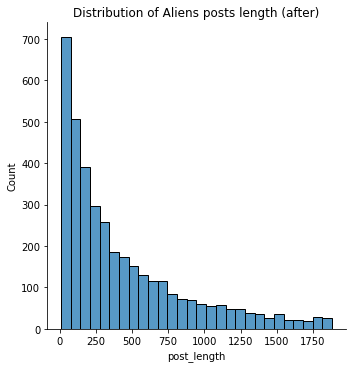

In [36]:
sns.displot(aliens_posts['post_length']).set(title='Distribution of Aliens posts length (after)');

## Check for duplicates

In [37]:
aliens_posts.shape

(3781, 3)

In [38]:
aliens_posts[aliens_posts['selftext'].duplicated()].head(6)

,subreddit,selftext,post_length
61,aliens,What are your views on The Matrix series by Va...,107.0
218,aliens,So this is interesting especially with space f...,334.0
219,aliens,So this is interesting especially with space f...,334.0
468,aliens,"I want to ""share/communicate an experience"" th...",124.0
569,aliens,"If aliens exist, would the know/make Art? Art...",711.0
570,aliens,"If aliens exist, would the know/make Art? Art...",711.0


## Drop duplicates

In [39]:
aliens_posts['selftext'] = aliens_posts['selftext'].drop_duplicates()

In [40]:
aliens_posts.shape

(3781, 3)

# Space

In [41]:
space_posts['post_length'].describe()

count     2361.000000
mean       430.167726
std        705.892306
min          9.000000
25%         90.000000
50%        251.000000
75%        495.000000
max      13460.000000
Name: post_length, dtype: float64

#### Before dropping outliers

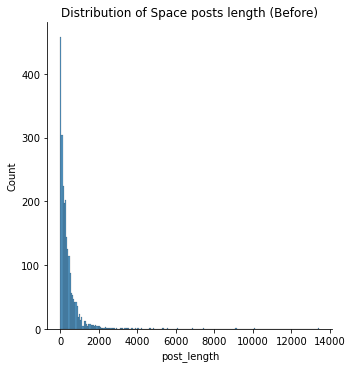

In [42]:
sns.displot(space_posts['post_length']).set(title='Distribution of Space posts length (Before)');

## Outliers identification and addressing

### There are abnormally large outliers in the word count for "Space" subreddit which will be removed.

#### Making use of Median Absolute Deviation to detect outliers

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.median_absolute_deviation.html

In [43]:
mad = stats.median_abs_deviation(space_posts['post_length'])

In [44]:
tsigma = space_posts['post_length'].median() + (space_posts['post_length'].std() * 3)

In [45]:
tsigma = aliens_posts['post_length'].median() + (mad * 6)

In [46]:
tsigma

1355.0

Posts length with more than 3 and less than 6*median_abs_deviation are kept to remove outliers

In [47]:
space_posts = space_posts[(space_posts['post_length'] < tsigma) & (space_posts['post_length'] > 3)]

In [48]:
space_posts.shape

(2239, 3)

#### After dropping outliers

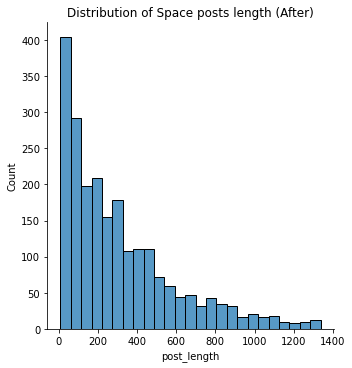

In [49]:
sns.displot(space_posts['post_length']).set(title='Distribution of Space posts length (After)');

## Check for duplicates

In [50]:
space_posts.shape

(2239, 3)

In [51]:
space_posts[space_posts['selftext'].duplicated()].head(6)

,subreddit,selftext,post_length
129,space,Snapdeal Customer Care Number ⓿❽❺❾❼❽❻❶❸❽⓿✔⓿❾❶⓿...,120.0
130,space,Snapdeal Customer Care Number ⓿❽❺❾❼❽❻❶❸❽⓿✔⓿❾❶⓿...,120.0
218,space,Space colors? Dumb question Sry Ready for a du...,103.0
622,space,Space hurricane [deleted],25.0
664,space,A Method for Creating Enormous Space Telescope...,78.0
1519,space,Cornell Postdoc Detects Possible Exoplanet Rad...,67.0


## Drop duplicates

In [52]:
space_posts['selftext'] = space_posts['selftext'].drop_duplicates()

In [53]:
space_posts[space_posts['selftext'].duplicated()].head(5)

,subreddit,selftext,post_length
130,space,NaN,120.0
218,space,NaN,103.0
622,space,NaN,25.0
664,space,NaN,78.0
1519,space,NaN,67.0


In [54]:
space_posts.shape

(2239, 3)

### 6b. Cleaning data

### Aliens

In [55]:
aliens_posts.head(3)

,subreddit,selftext,post_length
0,aliens,What do we know about the greys' anatomy? Does...,126.0
3,aliens,Help finding a video A video got posted on thi...,122.0
4,aliens,Exonews.org? I just found this site and it see...,174.0


In [56]:
aliens_posts['selftext'] = aliens_posts['selftext'].astype(str)

In [57]:
aliens_posts['selftext'] = aliens_posts['selftext'].dropna(how='any')

In [58]:
aliens_posts['selftext'] = aliens_posts['selftext'].map(removed_posts)

In [59]:
aliens_posts['selftext'] = aliens_posts['selftext'].map(redditcleaner.clean)

In [60]:
aliens_posts['selftext'] = aliens_posts['selftext'].map(clean_links)

In [61]:
aliens_posts['selftext'] = aliens_posts['selftext'].map(enc)

In [62]:
aliens_posts['selftext'] = aliens_posts['selftext'].map(punc)

In [63]:
aliens_posts = aliens_posts[aliens_posts['selftext'] != ""]

In [64]:
aliens_posts.shape

(3775, 3)

# Addressing likelihood of answering the problem statement with EDA data.

# Aliens

## Identification of common words that are likely to appear in feature importance after modeling using visualization tools like word cloud.

In [65]:
from wordcloud import WordCloud, STOPWORDS

In [66]:
aliens_cloud = aliens_posts

In [67]:
aliens_cloud['tok_text'] = aliens_cloud['selftext'].apply(lambda x: [token.text.strip().lower() for token in  nlp(x)])

In [68]:
text_cloud = aliens_cloud[['tok_text']].sum().sort_values(ascending=False).head(100).tolist()

In [69]:
t = " ".join(text_cloud[0])

In [70]:
wordcloud = WordCloud(collocations = False, min_font_size=10, max_font_size=100, width=1000, height=1000, max_words=200, background_color="white").generate(t)

## Word Cloud Visualization

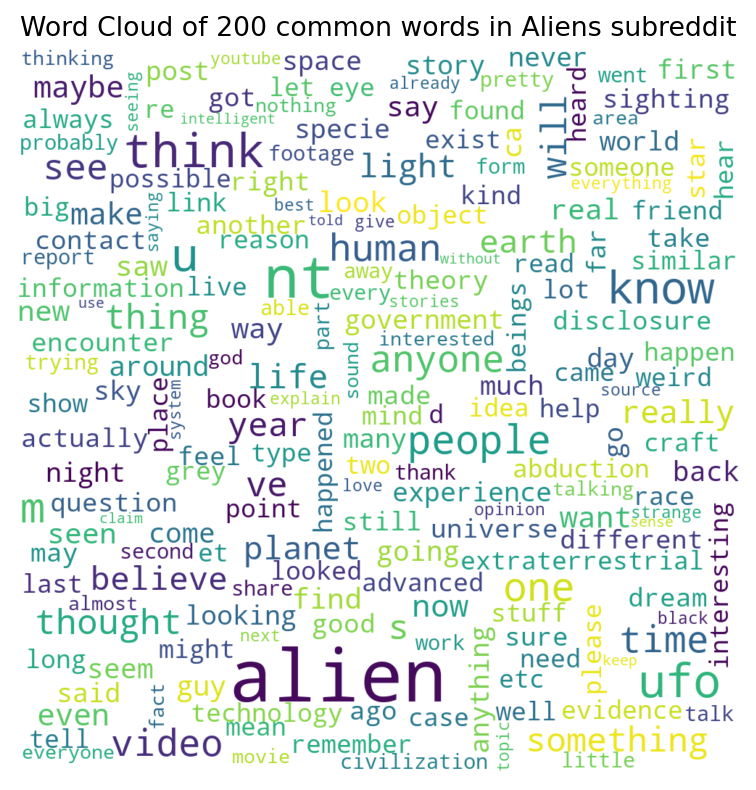

In [71]:
plt.figure(figsize=(8, 6), dpi=160)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of 200 common words in Aliens subreddit")
plt.show()

## Exploring stop words, stemming, and lemmatization methods to improve the classification score

## Aliens

##### Aliens - Tokenizing and lemmatizing and converting to lower case

In [72]:
ps = PorterStemmer()

In [73]:
aliens_posts['selftext']

0       What do we know about the greys anatomy Does a...
3       Help finding a video A video got posted on thi...
4       Exonewsorg I just found this site and it seems...
6       Heres something to think about There are more ...
7       Definitely not a hoax Alien or inner Earth Def...
                              ...                        
9979    Alien Themed Tattoo If you could get any alien...
9981    Im looking for a specific quote from Lazar he ...
9984    Possible UFO in Buncombe County NC 05072020 He...
9985    New NASA Citizen Science Project to Find Alien...
9986    How to know if what is saw was a alien Hell Gr...
Name: selftext, Length: 3775, dtype: object

In [74]:
aliens_posts['selftext'] = aliens_posts['selftext'].apply(lambda x: [token.text.strip().lower() for token in  nlp(x)]).str.join(' ')

In [75]:
## Stemming was not applied here as it affected the model interpretability and it reduced the model score.

# aliens_posts['selftext'] = aliens_posts['selftext'].apply(lambda x: [ps.stem(y) for y in  x]).str.join(' ')

In [76]:
aliens_posts.head(3)

,subreddit,selftext,post_length,tok_text
0,aliens,what do we know about the greys anatomy does a...,126.0,"[what, do, we, know, about, the, greys, anatom..."
3,aliens,help finding a video a video got posted on thi...,122.0,"[help, finding, a, video, a, video, got, poste..."
4,aliens,exonewsorg i just found this site and it seems...,174.0,"[exonewsorg, i, just, found, this, site, and, ..."


In [77]:
aliens_posts['selftext'] = aliens_posts['selftext'].apply(lambda x: [y.lemma_ for y in  nlp(x) if not y.is_stop]).str.join(' ')

In [78]:
aliens_posts.shape

(3775, 4)

In [79]:
aliens_posts.head(10)

,subreddit,selftext,post_length,tok_text
0,aliens,know grey anatomy know body like inside proces...,126.0,"[what, do, we, know, about, the, greys, anatom..."
3,aliens,help find video video got post sub maybe 2 mon...,122.0,"[help, finding, a, video, a, video, got, poste..."
4,aliens,exonewsorg find site pretty surprised legitima...,174.0,"[exonewsorg, i, just, found, this, site, and, ..."
6,aliens,here think galaxy grain sand planet earth cons...,406.0,"[heres, something, to, think, about, there, ar..."
7,aliens,definitely hoax alien inner earth definitely h...,949.0,"[definitely, not, a, hoax, alien, or, inner, e..."
10,aliens,silicon base life listen podcast discuss drake...,516.0,"[silicon, based, life, i, was, listening, to, ..."
11,aliens,explain appear balloon rotate tail section cle...,136.0,"[can, anyone, explain, why, these, what, appea..."
12,aliens,sky light recent source request past week stat...,273.0,"[sky, light, recent, source, request, for, the..."
13,aliens,explination dunno alien randy sure post boyfri...,1172.0,"[explination, dunno, about, aliens, but, randy..."
14,aliens,human able alien planet shower thought disclos...,681.0,"[humans, would, not, be, able, to, go, to, oth..."


### Space

In [80]:
space_posts['selftext'] = space_posts['selftext'].astype(str)

In [81]:
space_posts['selftext'] = space_posts['selftext'].dropna(how='any')

In [82]:
space_posts['selftext'] = space_posts['selftext'].map(removed_posts)

In [83]:
space_posts['selftext'] = space_posts['selftext'].map(redditcleaner.clean)

In [84]:
space_posts['selftext'] = space_posts['selftext'].map(clean_links)

In [85]:
space_posts['selftext'] = space_posts['selftext'].map(enc)

In [86]:
space_posts['selftext'] = space_posts['selftext'].map(punc)

In [87]:
space_posts = space_posts[space_posts['selftext'] != ""]

In [88]:
space_posts.shape

(2233, 3)

# Addressing likelihood of answering the problem statement with EDA data.

# Space

## Identification of common words that are likely to appear in feature importance after modeling using visualization tools like word cloud.

In [89]:
space_cloud = space_posts

In [90]:
space_cloud['tok_text'] = space_posts['selftext'].apply(lambda x: [token.text.strip().lower() for token in  nlp(x)])

In [91]:
text_cloud = space_cloud[['tok_text']].sum().sort_values(ascending=False).head(100).tolist()

In [92]:
t = " ".join(text_cloud[0])

In [93]:
wordcloud1 = WordCloud(collocations = False, min_font_size=10, max_font_size=100, width=1000, height=1000, max_words=200, background_color="white").generate(t)

## Word Cloud Visualization

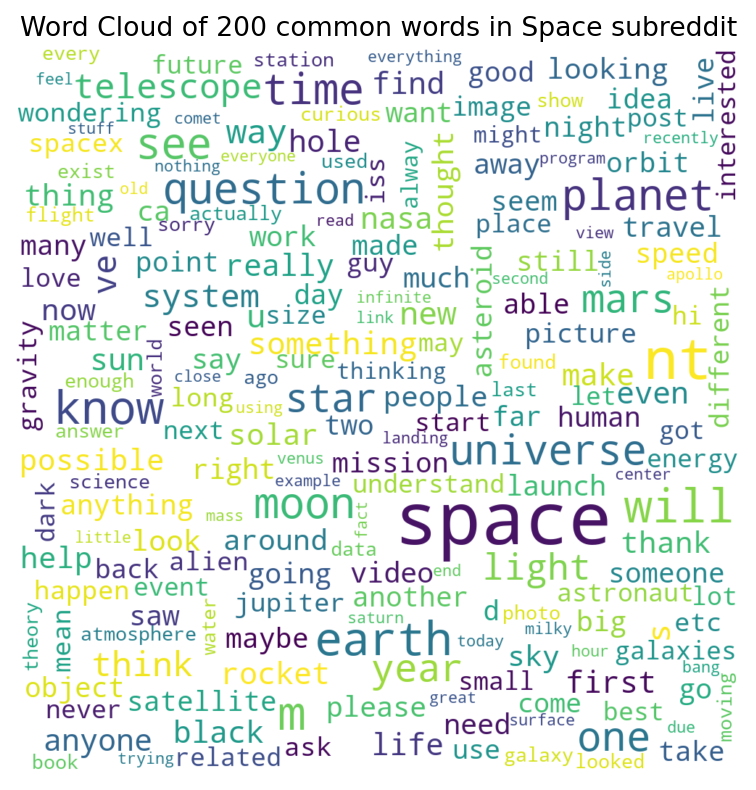

In [94]:
plt.figure(figsize=(8, 6), dpi=160)
plt.imshow(wordcloud1, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of 200 common words in Space subreddit")
plt.show()

# Answering problem statement from data discovered during EDA

From the word cloud, it can be seen that there seems to be a unique structure and make up of words of the subreddit.

This will likely improve the classification model accuracy.

Since the goal of the problem statement is to classify the posts according to their subreddits, the goal seems to be achieveable at this point in EDA.

## Exploring stop words, stemming, and lemmatization methods to improve the classification score

## Space

##### Space - Tokenizing and lemmatizing and converting to lower case

In [95]:
space_posts['selftext'] = space_posts['selftext'].apply(lambda x: [token.text.strip().lower() for token in  nlp(x)]).str.join(' ')

In [96]:
space_posts['selftext'] = space_posts['selftext'].apply(lambda x: [y.lemma_ for y in  nlp(x) if not y.is_stop]).str.join(' ')

In [97]:
## Stemming was not applied here as it affected the model interpretability and it reduced the model score.

# space_posts['selftext'] = space_posts['selftext'].apply(lambda x: [ps.stem(y) for y in  x]).str.join(' ')

In [98]:
space_posts.shape

(2233, 4)

In [99]:
space_posts.head(10)

,subreddit,selftext,post_length,tok_text
10,space,ban tired get subreddit suggest plz ban,82.0,"[can, someone, ban, me, i, am, tired, of, gett..."
15,space,hey love space hi 11 year old love learn spa...,332.0,"[hey, , i, love, space, again, hi, everyone, w..."
16,space,bright look east 700 o clock pm see bright obj...,512.0,"[something, bright, i, was, looking, east, at,..."
24,space,iss hold ham radio sstv event oct 4 8,70.0,"[the, iss, will, hold, a, ham, radio, sstv, ev..."
25,space,momentum grow nuclear thermal propulsion 2019,62.0,"[momentum, grows, for, nuclear, thermal, propu..."
32,space,space outside milky way look let float relativ...,443.0,"[if, you, were, in, space, outside, of, the, m..."
38,space,take pic moon morning notice bright thing righ...,124.0,"[took, this, pic, of, the, moon, this, morning..."
45,space,flat earth debate,28.0,"[flat, earth, debate]"
46,space,atlas interactive interactive solar system orr...,277.0,"[we, at, atlas, interactive, made, an, interac..."
49,space,scientific reason large gap space mar jupiter ...,238.0,"[is, there, any, scientific, reason, why, ther..."


In [100]:
space = space_posts.groupby("selftext")

In [101]:
space.describe().head()

post_length          \
                                                         count    mean   
selftext                                                                 
                                                           8.0    43.0   
    gaming   nft elite force host 50000 warzone...         1.0   165.0   
  interesting couriosity pluto   read article blog         1.0   454.0   
  question feel calm life peace happy ness read...         1.0   309.0   
  rainbow space   orcs odd radio circle orcs ne...         1.0  1124.0   

                                                                              \
                                                         std     min     25%   
selftext                                                                       
                                                    24.09505    11.0    20.5   
    gaming   nft elite force host 50000 warzone...       NaN   165.0   165.0   
  interesting couriosity pluto   read article blog       NaN   454.0   454.0   
  question feel calm life peace happy ness read...       NaN   309.0   309.0   
  rainbow space   orcs odd radio circle orcs ne...       NaN  1124.0  1124.0   

                                                                             
                                                       50%      75%     max  
selftext                                                                     
                                                      46.0    66.25    70.0  
    gaming   nft elite force host 50000 warzone...   165.0   165.00   165.0  
  interesting couriosity pluto   read article blog   454.0   454.00   454.0  
  question feel calm life peace happy ness read...   309.0   309.00   309.0  
  rainbow space   orcs odd radio circle orcs ne...  1124.0  1124.00  1124.0

### Append datasets

Check and drop rows to get approximately similar value counts.

In [102]:
aliens_posts = aliens_posts[aliens_posts['post_length'] > 200]

In [103]:
aliens_posts.shape

(2218, 4)

In [104]:
space_posts.shape

(2233, 4)

In [105]:
posts = aliens_posts.append(space_posts, ignore_index=True)
posts['subreddit'].unique()

array(['aliens', 'space'], dtype=object)

# A variety of models will be tested and evaluated to identify a production algorithm

1.  Naive Bayes
2. Random Forest
3. CatboostClassfication
4. Logistic Regression

## 7. Model Setup

In [106]:
import gensim
import gensim.downloader as api
from gensim.models.word2vec import Word2Vec
from transformers import pipeline

#### Model setup for Naive Bayers

## Splitting the data for validation/training purposes

In [107]:
X = posts[['selftext']]
y = posts['subreddit']

In [108]:
y.value_counts(normalize = True)

space     0.501685
aliens    0.498315
Name: subreddit, dtype: float64

In [109]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state = 42, stratify=y)

## Converting text data to matrix representation using CountVectorizer

In [110]:
# Import CountVectorizer.
from sklearn.feature_extraction.text import CountVectorizer

# Instantiate CountVectorizer.
cvec = CountVectorizer(max_features = 100000, stop_words = 'english')

In [111]:
X_train = X_train['selftext']

In [112]:
X_test = X_test['selftext']

In [113]:
cvec.fit_transform(X_train).todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [114]:
# Fit CountVectorizer on the training data and transform training data.
X_train_cvec = pd.DataFrame(
    cvec.fit_transform(X_train).todense(),
    columns = cvec.get_feature_names()
)

In [115]:
# 15 most common words - train

In [116]:
mostcommon = X_train_cvec.sum().sort_values(ascending=False).head(15)

In [117]:
common_df = pd.DataFrame(mostcommon).reset_index(drop=False).rename(columns={"index": "category", 0: "counts"})

In [118]:
common_df

,category,counts
0,alien,1936
1,like,1520
2,think,1252
3,know,1179
4,space,1169
5,look,875
6,time,748
7,people,703
8,earth,679
9,planet,645


In [119]:
# Transform testing data with the already-fit CountVectorizer.
X_test_cvec = pd.DataFrame(
    cvec.transform(X_test).todense(),
    columns = cvec.get_feature_names()
)

In [120]:
# 15 most common words - test

In [121]:
X_test_cvec.sum().sort_values(ascending=False).head(15)

alien     450
like      391
know      286
think     283
look      234
space     228
time      217
earth     172
people    161
video     159
ve        150
planet    150
light     149
year      146
life      133
dtype: int64

#### Visualizing 15 most common words in train dataset

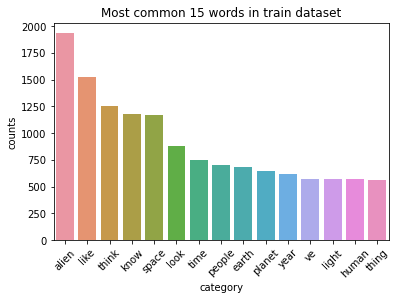

In [122]:
plt.xticks(rotation=45)
sns.barplot(x="category", y="counts", data=common_df).set(title='Most common 15 words in train dataset');

In [123]:
X_train_cvec.head()

,00,00042,00312,0033,012,014,01jan,020,029,02year,...,zoo,zookeeper,zoom,zoomedin,zorg,ztzrmhg,zubrin,zuckerberg,zugvi,zygote
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Getting baseline scores

In [124]:
# Pipeline & Gridsearch setup

# TFIDF pipeline setup
# mb
tfidf_mb_pipe = Pipeline([
 ('tvec', TfidfVectorizer()),
 ('mb', MultinomialNB())
])
# Randomforest
tfidf_rf_pipe = Pipeline([
 ('tvec', TfidfVectorizer()),
 ('rf', RandomForestClassifier())
])
# Catboost
tfidf_cat_pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('cbc', CatBoostClassifier())
])
# logistic regression
tfidf_lr_pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('lr', LogisticRegression())
])


# CVec pipeline setup
# mb
cvec_mb_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('mb', MultinomialNB())
])
# random forest
cvec_rf_pipe = Pipeline([
 ('cvec', CountVectorizer()),
 ('rf', RandomForestClassifier())
])
# Catboost
cvec_cat_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('cbc', CatBoostClassifier())
])
# logistic regression
cvec_lr_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression())
])


# Setting params for TFIDF params
tf_params = {   
}

# setting up cvec params
cvec_params = {
}

In [125]:
# Setting up GridSearch for tfidf
tfidf_mb_gs = GridSearchCV(tfidf_mb_pipe, param_grid=tf_params, cv = 5, verbose =1, n_jobs = -1)
tfidf_rf_gs = GridSearchCV(tfidf_rf_pipe, param_grid=tf_params, cv = 5, verbose =1, n_jobs = -1)
tfidf_lr_gs = GridSearchCV(tfidf_lr_pipe, param_grid=tf_params, cv = 5, verbose = 1, n_jobs = -1)
tfidf_cat_gs = GridSearchCV(tfidf_cat_pipe, param_grid=tf_params, cv = 5, verbose = 1, n_jobs = -1)


In [126]:
# Setting up GridSearch for cvec
cvec_mb_gs = GridSearchCV(cvec_mb_pipe, param_grid=cvec_params, cv = 5, verbose =1, n_jobs = -1)
cvec_rf_gs = GridSearchCV(cvec_rf_pipe, param_grid=cvec_params, cv = 5, verbose =1, n_jobs = -1)
cvec_lr_gs = GridSearchCV(cvec_lr_pipe, param_grid=cvec_params, cv = 5, verbose =1, n_jobs = -1)
cvec_cat_gs = GridSearchCV(cvec_cat_pipe, param_grid=cvec_params, cv = 5, verbose =1, n_jobs = -1)

In [127]:
tfidf_mb_gs.fit(X_train, y_train)
tfidf_rf_gs.fit(X_train, y_train)
tfidf_lr_gs.fit(X_train, y_train)
tfidf_cat_gs.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Learning rate set to 0.017718
0:	learn: 0.6811512	total: 199ms	remaining: 3m 19s
1:	learn: 0.6694601	total: 246ms	remaining: 2m 2s
2:	learn: 0.6581985	total: 289ms	remaining: 1m 36s
3:	learn: 0.6466637	total: 336ms	remaining: 1m 23s
4:	learn: 0.6355554	total: 382ms	remaining: 1m 15s
5:	learn: 0.6258991	total: 429ms	remaining: 1m 11s
6:	learn: 0.6164824	total: 475ms	remaining: 1m 7s
7:	learn: 0.6081269	total: 520ms	remaining: 1m 4s
8:	learn: 0.5986154	total: 566ms	remaining: 1m 2s
9:	learn: 0.5898635	total: 613ms	remaining: 1m
10:	learn: 0.5827350	total: 660ms	remaining: 59.3s
11:	learn: 0.5746050	total: 705ms	remaining: 58s
12:	learn: 0.5685953	total: 752ms	remaining: 57.1s
13:	learn: 0.5617110	total: 800ms	remaining: 56.3s
14:	learn: 0.5551044	total: 84

160:	learn: 0.3106740	total: 7.71s	remaining: 40.2s
161:	learn: 0.3103533	total: 7.76s	remaining: 40.1s
162:	learn: 0.3098047	total: 7.81s	remaining: 40.1s
163:	learn: 0.3092220	total: 7.86s	remaining: 40s
164:	learn: 0.3087986	total: 7.9s	remaining: 40s
165:	learn: 0.3083228	total: 7.95s	remaining: 40s
166:	learn: 0.3078739	total: 8s	remaining: 39.9s
167:	learn: 0.3074936	total: 8.04s	remaining: 39.8s
168:	learn: 0.3068908	total: 8.09s	remaining: 39.8s
169:	learn: 0.3063883	total: 8.14s	remaining: 39.7s
170:	learn: 0.3059797	total: 8.19s	remaining: 39.7s
171:	learn: 0.3054866	total: 8.24s	remaining: 39.7s
172:	learn: 0.3050545	total: 8.28s	remaining: 39.6s
173:	learn: 0.3047048	total: 8.33s	remaining: 39.5s
174:	learn: 0.3041857	total: 8.38s	remaining: 39.5s
175:	learn: 0.3036841	total: 8.43s	remaining: 39.5s
176:	learn: 0.3033602	total: 8.47s	remaining: 39.4s
177:	learn: 0.3028747	total: 8.52s	remaining: 39.3s
178:	learn: 0.3024601	total: 8.57s	remaining: 39.3s
179:	learn: 0.3018371	

319:	learn: 0.2565647	total: 15.2s	remaining: 32.3s
320:	learn: 0.2563081	total: 15.3s	remaining: 32.3s
321:	learn: 0.2559898	total: 15.3s	remaining: 32.3s
322:	learn: 0.2557471	total: 15.4s	remaining: 32.2s
323:	learn: 0.2555644	total: 15.4s	remaining: 32.2s
324:	learn: 0.2554067	total: 15.5s	remaining: 32.1s
325:	learn: 0.2552050	total: 15.5s	remaining: 32.1s
326:	learn: 0.2550496	total: 15.6s	remaining: 32s
327:	learn: 0.2548323	total: 15.6s	remaining: 32s
328:	learn: 0.2546653	total: 15.6s	remaining: 31.9s
329:	learn: 0.2543618	total: 15.7s	remaining: 31.9s
330:	learn: 0.2540782	total: 15.7s	remaining: 31.8s
331:	learn: 0.2538864	total: 15.8s	remaining: 31.8s
332:	learn: 0.2536809	total: 15.8s	remaining: 31.7s
333:	learn: 0.2534637	total: 15.9s	remaining: 31.7s
334:	learn: 0.2532706	total: 15.9s	remaining: 31.6s
335:	learn: 0.2529668	total: 16s	remaining: 31.6s
336:	learn: 0.2527967	total: 16s	remaining: 31.5s
337:	learn: 0.2524914	total: 16.1s	remaining: 31.5s
338:	learn: 0.252285

482:	learn: 0.2269975	total: 22.9s	remaining: 24.5s
483:	learn: 0.2269140	total: 23s	remaining: 24.5s
484:	learn: 0.2266874	total: 23s	remaining: 24.4s
485:	learn: 0.2265406	total: 23.1s	remaining: 24.4s
486:	learn: 0.2263095	total: 23.1s	remaining: 24.3s
487:	learn: 0.2262503	total: 23.2s	remaining: 24.3s
488:	learn: 0.2261693	total: 23.2s	remaining: 24.2s
489:	learn: 0.2259554	total: 23.2s	remaining: 24.2s
490:	learn: 0.2258612	total: 23.3s	remaining: 24.1s
491:	learn: 0.2257701	total: 23.3s	remaining: 24.1s
492:	learn: 0.2256718	total: 23.4s	remaining: 24.1s
493:	learn: 0.2256028	total: 23.4s	remaining: 24s
494:	learn: 0.2254765	total: 23.5s	remaining: 24s
495:	learn: 0.2253350	total: 23.5s	remaining: 23.9s
496:	learn: 0.2252516	total: 23.6s	remaining: 23.9s
497:	learn: 0.2251310	total: 23.6s	remaining: 23.8s
498:	learn: 0.2250464	total: 23.7s	remaining: 23.8s
499:	learn: 0.2249670	total: 23.7s	remaining: 23.7s
500:	learn: 0.2249180	total: 23.8s	remaining: 23.7s
501:	learn: 0.224826

641:	learn: 0.2027934	total: 30.4s	remaining: 16.9s
642:	learn: 0.2027031	total: 30.4s	remaining: 16.9s
643:	learn: 0.2024507	total: 30.5s	remaining: 16.8s
644:	learn: 0.2022192	total: 30.5s	remaining: 16.8s
645:	learn: 0.2021415	total: 30.6s	remaining: 16.7s
646:	learn: 0.2020944	total: 30.6s	remaining: 16.7s
647:	learn: 0.2020253	total: 30.6s	remaining: 16.6s
648:	learn: 0.2017909	total: 30.7s	remaining: 16.6s
649:	learn: 0.2017413	total: 30.7s	remaining: 16.6s
650:	learn: 0.2015907	total: 30.8s	remaining: 16.5s
651:	learn: 0.2014868	total: 30.8s	remaining: 16.5s
652:	learn: 0.2012642	total: 30.9s	remaining: 16.4s
653:	learn: 0.2011951	total: 30.9s	remaining: 16.4s
654:	learn: 0.2009077	total: 31s	remaining: 16.3s
655:	learn: 0.2008597	total: 31s	remaining: 16.3s
656:	learn: 0.2007104	total: 31.1s	remaining: 16.2s
657:	learn: 0.2006200	total: 31.1s	remaining: 16.2s
658:	learn: 0.2005485	total: 31.2s	remaining: 16.1s
659:	learn: 0.2004740	total: 31.2s	remaining: 16.1s
660:	learn: 0.20

802:	learn: 0.1819415	total: 38.3s	remaining: 9.39s
803:	learn: 0.1818556	total: 38.3s	remaining: 9.34s
804:	learn: 0.1817936	total: 38.4s	remaining: 9.29s
805:	learn: 0.1817553	total: 38.4s	remaining: 9.24s
806:	learn: 0.1816939	total: 38.5s	remaining: 9.2s
807:	learn: 0.1816563	total: 38.5s	remaining: 9.15s
808:	learn: 0.1814956	total: 38.5s	remaining: 9.1s
809:	learn: 0.1814396	total: 38.6s	remaining: 9.05s
810:	learn: 0.1813999	total: 38.6s	remaining: 9s
811:	learn: 0.1813608	total: 38.7s	remaining: 8.96s
812:	learn: 0.1811524	total: 38.7s	remaining: 8.91s
813:	learn: 0.1810684	total: 38.8s	remaining: 8.86s
814:	learn: 0.1810297	total: 38.8s	remaining: 8.81s
815:	learn: 0.1809621	total: 38.9s	remaining: 8.76s
816:	learn: 0.1808621	total: 38.9s	remaining: 8.72s
817:	learn: 0.1808256	total: 39s	remaining: 8.67s
818:	learn: 0.1805318	total: 39s	remaining: 8.62s
819:	learn: 0.1804950	total: 39.1s	remaining: 8.57s
820:	learn: 0.1803835	total: 39.1s	remaining: 8.53s
821:	learn: 0.1802563

962:	learn: 0.1649876	total: 46s	remaining: 1.76s
963:	learn: 0.1649549	total: 46s	remaining: 1.72s
964:	learn: 0.1648789	total: 46.1s	remaining: 1.67s
965:	learn: 0.1647276	total: 46.1s	remaining: 1.62s
966:	learn: 0.1646944	total: 46.1s	remaining: 1.57s
967:	learn: 0.1645341	total: 46.2s	remaining: 1.53s
968:	learn: 0.1645021	total: 46.2s	remaining: 1.48s
969:	learn: 0.1644695	total: 46.3s	remaining: 1.43s
970:	learn: 0.1644189	total: 46.3s	remaining: 1.38s
971:	learn: 0.1643336	total: 46.4s	remaining: 1.34s
972:	learn: 0.1642666	total: 46.4s	remaining: 1.29s
973:	learn: 0.1641479	total: 46.5s	remaining: 1.24s
974:	learn: 0.1640309	total: 46.5s	remaining: 1.19s
975:	learn: 0.1638834	total: 46.6s	remaining: 1.15s
976:	learn: 0.1638293	total: 46.6s	remaining: 1.1s
977:	learn: 0.1637970	total: 46.7s	remaining: 1.05s
978:	learn: 0.1637257	total: 46.7s	remaining: 1s
979:	learn: 0.1635624	total: 46.8s	remaining: 954ms
980:	learn: 0.1635157	total: 46.8s	remaining: 906ms
981:	learn: 0.163484

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('cbc',
                                        <catboost.core.CatBoostClassifier object at 0x0000020B00405C70>)]),
             n_jobs=-1, param_grid={}, verbose=1)

In [128]:
cvec_mb_gs.fit(X_train, y_train)
cvec_rf_gs.fit(X_train, y_train)
cvec_lr_gs.fit(X_train, y_train)
cvec_cat_gs.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Learning rate set to 0.017718
0:	learn: 0.6798753	total: 26.5ms	remaining: 26.5s
1:	learn: 0.6678445	total: 52.4ms	remaining: 26.1s
2:	learn: 0.6573597	total: 78.3ms	remaining: 26s
3:	learn: 0.6458785	total: 103ms	remaining: 25.7s
4:	learn: 0.6364295	total: 141ms	remaining: 28.1s
5:	learn: 0.6262926	total: 165ms	remaining: 27.3s
6:	learn: 0.6162397	total: 191ms	remaining: 27.1s
7:	learn: 0.6075387	total: 217ms	remaining: 26.9s
8:	learn: 0.5986346	total: 243ms	remaining: 26.8s
9:	learn: 0.5901680	total: 269ms	remaining: 26.6s
10:	learn: 0.5815508	total: 294ms	remaining: 26.4s
11:	learn: 0.5745119	total: 320ms	remaining: 26.3s
12:	learn: 0.5678697	total: 345ms	remaining: 26.2s
13:	learn: 0.5607737	total: 371ms	remaining: 26.1s
14:	learn: 0.5531832	total: 3

161:	learn: 0.3163062	total: 4.06s	remaining: 21s
162:	learn: 0.3158006	total: 4.08s	remaining: 21s
163:	learn: 0.3153358	total: 4.11s	remaining: 20.9s
164:	learn: 0.3149230	total: 4.13s	remaining: 20.9s
165:	learn: 0.3144085	total: 4.15s	remaining: 20.9s
166:	learn: 0.3137304	total: 4.18s	remaining: 20.8s
167:	learn: 0.3134020	total: 4.2s	remaining: 20.8s
168:	learn: 0.3130485	total: 4.23s	remaining: 20.8s
169:	learn: 0.3126301	total: 4.25s	remaining: 20.8s
170:	learn: 0.3122318	total: 4.28s	remaining: 20.7s
171:	learn: 0.3118014	total: 4.3s	remaining: 20.7s
172:	learn: 0.3114358	total: 4.33s	remaining: 20.7s
173:	learn: 0.3109645	total: 4.35s	remaining: 20.7s
174:	learn: 0.3105242	total: 4.38s	remaining: 20.6s
175:	learn: 0.3099100	total: 4.4s	remaining: 20.6s
176:	learn: 0.3096163	total: 4.43s	remaining: 20.6s
177:	learn: 0.3092696	total: 4.45s	remaining: 20.6s
178:	learn: 0.3088618	total: 4.47s	remaining: 20.5s
179:	learn: 0.3085854	total: 4.5s	remaining: 20.5s
180:	learn: 0.308327

321:	learn: 0.2690129	total: 8.01s	remaining: 16.9s
322:	learn: 0.2688025	total: 8.03s	remaining: 16.8s
323:	learn: 0.2686419	total: 8.06s	remaining: 16.8s
324:	learn: 0.2684357	total: 8.08s	remaining: 16.8s
325:	learn: 0.2682469	total: 8.11s	remaining: 16.8s
326:	learn: 0.2681269	total: 8.13s	remaining: 16.7s
327:	learn: 0.2680150	total: 8.16s	remaining: 16.7s
328:	learn: 0.2678354	total: 8.18s	remaining: 16.7s
329:	learn: 0.2676091	total: 8.2s	remaining: 16.7s
330:	learn: 0.2675712	total: 8.23s	remaining: 16.6s
331:	learn: 0.2673321	total: 8.25s	remaining: 16.6s
332:	learn: 0.2672647	total: 8.28s	remaining: 16.6s
333:	learn: 0.2670987	total: 8.3s	remaining: 16.6s
334:	learn: 0.2668909	total: 8.32s	remaining: 16.5s
335:	learn: 0.2666632	total: 8.35s	remaining: 16.5s
336:	learn: 0.2664385	total: 8.37s	remaining: 16.5s
337:	learn: 0.2661454	total: 8.4s	remaining: 16.4s
338:	learn: 0.2661035	total: 8.42s	remaining: 16.4s
339:	learn: 0.2658897	total: 8.45s	remaining: 16.4s
340:	learn: 0.2

482:	learn: 0.2426967	total: 11.9s	remaining: 12.8s
483:	learn: 0.2425708	total: 12s	remaining: 12.8s
484:	learn: 0.2421533	total: 12s	remaining: 12.7s
485:	learn: 0.2419947	total: 12s	remaining: 12.7s
486:	learn: 0.2416711	total: 12s	remaining: 12.7s
487:	learn: 0.2414374	total: 12.1s	remaining: 12.7s
488:	learn: 0.2413689	total: 12.1s	remaining: 12.6s
489:	learn: 0.2413061	total: 12.1s	remaining: 12.6s
490:	learn: 0.2412357	total: 12.1s	remaining: 12.6s
491:	learn: 0.2410108	total: 12.2s	remaining: 12.6s
492:	learn: 0.2409274	total: 12.2s	remaining: 12.5s
493:	learn: 0.2408371	total: 12.2s	remaining: 12.5s
494:	learn: 0.2405837	total: 12.2s	remaining: 12.5s
495:	learn: 0.2404663	total: 12.3s	remaining: 12.5s
496:	learn: 0.2402024	total: 12.3s	remaining: 12.4s
497:	learn: 0.2399733	total: 12.3s	remaining: 12.4s
498:	learn: 0.2399033	total: 12.3s	remaining: 12.4s
499:	learn: 0.2396822	total: 12.4s	remaining: 12.4s
500:	learn: 0.2396365	total: 12.4s	remaining: 12.3s
501:	learn: 0.239422

649:	learn: 0.2158112	total: 16s	remaining: 8.63s
650:	learn: 0.2157010	total: 16.1s	remaining: 8.61s
651:	learn: 0.2154838	total: 16.1s	remaining: 8.58s
652:	learn: 0.2153971	total: 16.1s	remaining: 8.56s
653:	learn: 0.2152021	total: 16.1s	remaining: 8.53s
654:	learn: 0.2150134	total: 16.2s	remaining: 8.51s
655:	learn: 0.2149678	total: 16.2s	remaining: 8.48s
656:	learn: 0.2146496	total: 16.2s	remaining: 8.46s
657:	learn: 0.2145675	total: 16.2s	remaining: 8.43s
658:	learn: 0.2142906	total: 16.3s	remaining: 8.41s
659:	learn: 0.2142454	total: 16.3s	remaining: 8.38s
660:	learn: 0.2139688	total: 16.3s	remaining: 8.36s
661:	learn: 0.2138888	total: 16.3s	remaining: 8.34s
662:	learn: 0.2138183	total: 16.3s	remaining: 8.31s
663:	learn: 0.2135202	total: 16.4s	remaining: 8.29s
664:	learn: 0.2133251	total: 16.4s	remaining: 8.26s
665:	learn: 0.2131660	total: 16.4s	remaining: 8.23s
666:	learn: 0.2129075	total: 16.4s	remaining: 8.21s
667:	learn: 0.2127216	total: 16.5s	remaining: 8.19s
668:	learn: 0.

810:	learn: 0.1957942	total: 19.9s	remaining: 4.65s
811:	learn: 0.1956164	total: 20s	remaining: 4.62s
812:	learn: 0.1955840	total: 20s	remaining: 4.6s
813:	learn: 0.1953880	total: 20s	remaining: 4.57s
814:	learn: 0.1953531	total: 20s	remaining: 4.55s
815:	learn: 0.1953161	total: 20.1s	remaining: 4.52s
816:	learn: 0.1952541	total: 20.1s	remaining: 4.5s
817:	learn: 0.1951936	total: 20.1s	remaining: 4.47s
818:	learn: 0.1950832	total: 20.1s	remaining: 4.45s
819:	learn: 0.1948722	total: 20.2s	remaining: 4.42s
820:	learn: 0.1947812	total: 20.2s	remaining: 4.4s
821:	learn: 0.1947438	total: 20.2s	remaining: 4.38s
822:	learn: 0.1946830	total: 20.2s	remaining: 4.35s
823:	learn: 0.1944668	total: 20.3s	remaining: 4.33s
824:	learn: 0.1944305	total: 20.3s	remaining: 4.3s
825:	learn: 0.1943935	total: 20.3s	remaining: 4.28s
826:	learn: 0.1941985	total: 20.3s	remaining: 4.25s
827:	learn: 0.1941436	total: 20.4s	remaining: 4.23s
828:	learn: 0.1938904	total: 20.4s	remaining: 4.2s
829:	learn: 0.1938541	tot

969:	learn: 0.1806382	total: 23.8s	remaining: 737ms
970:	learn: 0.1806077	total: 23.9s	remaining: 713ms
971:	learn: 0.1804885	total: 23.9s	remaining: 688ms
972:	learn: 0.1804581	total: 23.9s	remaining: 664ms
973:	learn: 0.1804292	total: 23.9s	remaining: 639ms
974:	learn: 0.1802967	total: 24s	remaining: 614ms
975:	learn: 0.1800656	total: 24s	remaining: 590ms
976:	learn: 0.1800141	total: 24s	remaining: 565ms
977:	learn: 0.1798752	total: 24s	remaining: 541ms
978:	learn: 0.1798457	total: 24.1s	remaining: 516ms
979:	learn: 0.1798154	total: 24.1s	remaining: 491ms
980:	learn: 0.1797850	total: 24.1s	remaining: 467ms
981:	learn: 0.1797376	total: 24.1s	remaining: 442ms
982:	learn: 0.1796862	total: 24.2s	remaining: 418ms
983:	learn: 0.1796557	total: 24.2s	remaining: 393ms
984:	learn: 0.1796051	total: 24.2s	remaining: 369ms
985:	learn: 0.1794482	total: 24.2s	remaining: 344ms
986:	learn: 0.1794183	total: 24.2s	remaining: 319ms
987:	learn: 0.1793828	total: 24.3s	remaining: 295ms
988:	learn: 0.179298

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('cbc',
                                        <catboost.core.CatBoostClassifier object at 0x0000020B004056A0>)]),
             n_jobs=-1, param_grid={}, verbose=1)

In [129]:
print('Baseline Scores:')
print('-')
print('TFIDF scores:')
print('-----------------')
print('tfidf_mb_gs training set score: ',tfidf_mb_gs.score(X_train, y_train))
print('tfidf_mb_gs testing set score: ',tfidf_mb_gs.score(X_test, y_test))
print('spread = ',tfidf_mb_gs.score(X_train, y_train) - tfidf_mb_gs.score(X_test, y_test))
print('-')
print('tfidf_rf_gs training set score: ',tfidf_rf_gs.score(X_train, y_train))
print('tfidf_rf_gs testing set score: ',tfidf_rf_gs.score(X_test, y_test))
print('spread = ',tfidf_rf_gs.score(X_train, y_train) - tfidf_rf_gs.score(X_test, y_test))
print('-')
print('tfidf_lr_gs training set score: ',tfidf_lr_gs.score(X_train, y_train))
print('tfidf_lr_gs testing set score: ',tfidf_lr_gs.score(X_test, y_test))
print('spread = ',tfidf_lr_gs.score(X_train, y_train) - tfidf_lr_gs.score(X_test, y_test))
print('-')
print('tfidf_cat_gs training set score: ',tfidf_cat_gs.score(X_train, y_train))
print('tfidf_cat_gs testing set score: ',tfidf_cat_gs.score(X_test, y_test))
print('spread = ',tfidf_cat_gs.score(X_train, y_train) - tfidf_cat_gs.score(X_test, y_test))
print('-')
print(' ')
print('CVec scores: ')
print('-----------------')
print('cvec_mb_gs training set score: ',cvec_mb_gs.score(X_train, y_train))
print('cvec_mb_gs testing set score: ',cvec_mb_gs.score(X_test, y_test))
print('spread = ',cvec_mb_gs.score(X_train, y_train) - cvec_mb_gs.score(X_test, y_test))
print('-')
print('cvec_rf_gs training set score: ',cvec_rf_gs.score(X_train, y_train))
print('cvec_rf_gs testing set score: ',cvec_rf_gs.score(X_test, y_test))
print('spread = ',cvec_rf_gs.score(X_train, y_train) - cvec_rf_gs.score(X_test, y_test))
print('-')
print('cvec_lr_gs training set score: ',cvec_lr_gs.score(X_train, y_train))
print('cvec_lr_gs testing set score: ',cvec_lr_gs.score(X_test, y_test))
print('spread = ',cvec_lr_gs.score(X_train, y_train) - cvec_lr_gs.score(X_test, y_test))
print('-')
print('cvec_cat_gs training set score: ',cvec_cat_gs.score(X_train, y_train))
print('cvec_cat_gs testing set score: ',cvec_cat_gs.score(X_test, y_test))
print('spread = ',cvec_cat_gs.score(X_train, y_train) - cvec_cat_gs.score(X_test, y_test))
print('-')

Baseline Scores:
-
TFIDF scores:
-----------------
tfidf_mb_gs training set score:  0.9404494382022472
tfidf_mb_gs testing set score:  0.8843995510662177
spread =  0.05604988713602954
-
tfidf_rf_gs training set score:  0.9969101123595505
tfidf_rf_gs testing set score:  0.8956228956228957
spread =  0.10128721673665486
-
tfidf_lr_gs training set score:  0.9570224719101124
tfidf_lr_gs testing set score:  0.9158249158249159
spread =  0.041197556085196485
-
tfidf_cat_gs training set score:  0.9623595505617978
tfidf_cat_gs testing set score:  0.8978675645342312
spread =  0.06449198602756656
-
 
CVec scores: 
-----------------
cvec_mb_gs training set score:  0.9508426966292135
cvec_mb_gs testing set score:  0.898989898989899
spread =  0.051852797639314496
-
cvec_rf_gs training set score:  0.9969101123595505
cvec_rf_gs testing set score:  0.8911335578002245
spread =  0.105776554559326
-
cvec_lr_gs training set score:  0.9924157303370786
cvec_lr_gs testing set score:  0.9057239057239057
spread 

## TFIDF - Pipeline, Params

#### Naive Bayers

In [130]:
tfidf_mb_pipe = Pipeline([
 ('tvec', TfidfVectorizer()),
 ('mb', MultinomialNB())
])

In [131]:
tfmb_params = {
    ## TFIDF
    'tvec__stop_words': [None, 'english'],
    'tvec__ngram_range': [(1, 1), (1, 2)],
    'tvec__max_features': [1000, 5000, 10000],
    'mb__alpha': [1, 2, 3, 4]
}

#### Random Forest

In [132]:
tfidf_rf_pipe = Pipeline([
 ('tvec', TfidfVectorizer()),
 ('rf', RandomForestClassifier())
])

In [133]:
rf_params = {
    ## TFIDF
    'tvec__stop_words': [None, 'english'],
    'tvec__ngram_range': [(1, 1), (1, 2)],
    'tvec__max_features': [1000, 5000, 10000],
    ## Random Forest
    'rf__n_estimators': [400, 500],
    'rf__max_depth': [500, 600],
    'rf__min_samples_split': [3, 5],
    'rf__max_leaf_nodes': [None],
    'rf__random_state': [42]
}

#### Catboost

In [134]:
tfidf_cat_pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('cbc', CatBoostClassifier())
])

In [135]:
cb_params = {
    ## TFIDF
    'tvec__stop_words': [None, 'english'],
    'tvec__ngram_range': [(1, 1), (1, 2)],
    'tvec__max_features': [1000, 5000, 10000],
    ## Catboost
     'cbc__one_hot_max_size': [2, 10],
     'cbc__iterations': [500],
     'cbc__l2_leaf_reg': [3.0],
     'cbc__random_strength': [3.0],
     'cbc__eval_metric': ['Accuracy'],
     'cbc__random_seed': [42],
}

#### Logistic Regression

In [136]:
tfidf_lr_pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('lr', LogisticRegression())
])

In [137]:
lr_params = {
    ## TFIDF
    'tvec__stop_words': [None, 'english'],
    'tvec__ngram_range': [(1, 1), (1, 2)],
    'tvec__max_features': [1000, 5000, 10000],
    ## Logistic Regression
    'lr__penalty' : ['l1', 'l2', 'elasticnet'],
    'lr__C' : np.logspace(-4, 4, 20),
    'lr__solver' : ['liblinear']
}

## TFIDF - Params GridSearch

In [138]:
# Setting up GridSearch for tfidf
tfidf_mb_gs = GridSearchCV(tfidf_mb_pipe, param_grid=tfmb_params, cv = 5, verbose =1, n_jobs = -1)
tfidf_rf_gs = GridSearchCV(tfidf_rf_pipe, param_grid=rf_params, cv = 5, verbose =1, n_jobs = -1)
tfidf_lr_gs = GridSearchCV(tfidf_lr_pipe, param_grid=lr_params, cv = 5, verbose = 1, n_jobs = -1)
tfidf_cat_gs = GridSearchCV(tfidf_cat_pipe, param_grid=cb_params, cv = 5, verbose = 1, n_jobs = -1)

### TFIDF Multinomial Naive Bayers

In [139]:
tfidf_mb_gs.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('mb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'mb__alpha': [1, 2, 3, 4],
                         'tvec__max_features': [1000, 5000, 10000],
                         'tvec__ngram_range': [(1, 1), (1, 2)],
                         'tvec__stop_words': [None, 'english']},
             verbose=1)

### TFIDF Random Forest

In [140]:
tfidf_rf_gs.fit(X_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [500, 600],
                         'rf__max_leaf_nodes': [None],
                         'rf__min_samples_split': [3, 5],
                         'rf__n_estimators': [400, 500],
                         'rf__random_state': [42],
                         'tvec__max_features': [1000, 5000, 10000],
                         'tvec__ngram_range': [(1, 1), (1, 2)],
                         'tvec__stop_words': [None, 'english']},
             verbose=1)

### TFIDF Catboost

In [141]:
tfidf_cat_gs.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
0:	learn: 0.7328652	total: 39.3ms	remaining: 19.6s
1:	learn: 0.7536517	total: 76.9ms	remaining: 19.2s
2:	learn: 0.7497191	total: 115ms	remaining: 19s
3:	learn: 0.7617978	total: 152ms	remaining: 18.8s
4:	learn: 0.7567416	total: 187ms	remaining: 18.5s
5:	learn: 0.7710674	total: 226ms	remaining: 18.6s
6:	learn: 0.8019663	total: 269ms	remaining: 19s
7:	learn: 0.8019663	total: 307ms	remaining: 18.9s
8:	learn: 0.8025281	total: 347ms	remaining: 18.9s
9:	learn: 0.8036517	total: 386ms	remaining: 18.9s
10:	learn: 0.8019663	total: 424ms	remaining: 18.8s
11:	learn: 0.8044944	total: 460ms	remaining: 18.7s
12:	learn: 0.8042135	total: 496ms	remaining: 18.6s
13:	learn: 0.8050562	total: 530ms	remaining: 18.4s
14:	learn: 0.8042135	total: 564ms	remaining: 18.2s
15:	learn: 0.8025281	total: 598ms	remaining: 18.1s
16:	learn: 0.8025281	total: 631ms	remaining: 17.9s
17:	learn: 0.8019663	total: 664ms	remaining: 17.8s
18:	learn: 0.8022472	total: 707m

165:	learn: 0.8887640	total: 5.89s	remaining: 11.9s
166:	learn: 0.8884831	total: 5.93s	remaining: 11.8s
167:	learn: 0.8887640	total: 5.97s	remaining: 11.8s
168:	learn: 0.8893258	total: 6s	remaining: 11.8s
169:	learn: 0.8896067	total: 6.04s	remaining: 11.7s
170:	learn: 0.8898876	total: 6.07s	remaining: 11.7s
171:	learn: 0.8904494	total: 6.1s	remaining: 11.6s
172:	learn: 0.8904494	total: 6.14s	remaining: 11.6s
173:	learn: 0.8907303	total: 6.17s	remaining: 11.6s
174:	learn: 0.8912921	total: 6.21s	remaining: 11.5s
175:	learn: 0.8912921	total: 6.24s	remaining: 11.5s
176:	learn: 0.8910112	total: 6.27s	remaining: 11.4s
177:	learn: 0.8907303	total: 6.31s	remaining: 11.4s
178:	learn: 0.8907303	total: 6.34s	remaining: 11.4s
179:	learn: 0.8907303	total: 6.4s	remaining: 11.4s
180:	learn: 0.8912921	total: 6.45s	remaining: 11.4s
181:	learn: 0.8915730	total: 6.48s	remaining: 11.3s
182:	learn: 0.8921348	total: 6.51s	remaining: 11.3s
183:	learn: 0.8924157	total: 6.55s	remaining: 11.2s
184:	learn: 0.893

329:	learn: 0.9221910	total: 11.6s	remaining: 5.95s
330:	learn: 0.9230337	total: 11.6s	remaining: 5.92s
331:	learn: 0.9230337	total: 11.6s	remaining: 5.88s
332:	learn: 0.9227528	total: 11.7s	remaining: 5.85s
333:	learn: 0.9227528	total: 11.7s	remaining: 5.81s
334:	learn: 0.9227528	total: 11.7s	remaining: 5.78s
335:	learn: 0.9230337	total: 11.8s	remaining: 5.74s
336:	learn: 0.9230337	total: 11.8s	remaining: 5.71s
337:	learn: 0.9233146	total: 11.8s	remaining: 5.67s
338:	learn: 0.9233146	total: 11.9s	remaining: 5.64s
339:	learn: 0.9241573	total: 11.9s	remaining: 5.6s
340:	learn: 0.9244382	total: 11.9s	remaining: 5.57s
341:	learn: 0.9250000	total: 12s	remaining: 5.53s
342:	learn: 0.9252809	total: 12s	remaining: 5.5s
343:	learn: 0.9255618	total: 12s	remaining: 5.46s
344:	learn: 0.9255618	total: 12.1s	remaining: 5.42s
345:	learn: 0.9261236	total: 12.1s	remaining: 5.39s
346:	learn: 0.9275281	total: 12.1s	remaining: 5.35s
347:	learn: 0.9278090	total: 12.2s	remaining: 5.32s
348:	learn: 0.927528

488:	learn: 0.9500000	total: 17.1s	remaining: 385ms
489:	learn: 0.9500000	total: 17.1s	remaining: 350ms
490:	learn: 0.9500000	total: 17.2s	remaining: 315ms
491:	learn: 0.9500000	total: 17.2s	remaining: 280ms
492:	learn: 0.9500000	total: 17.2s	remaining: 245ms
493:	learn: 0.9502809	total: 17.3s	remaining: 210ms
494:	learn: 0.9508427	total: 17.3s	remaining: 175ms
495:	learn: 0.9505618	total: 17.4s	remaining: 140ms
496:	learn: 0.9505618	total: 17.4s	remaining: 105ms
497:	learn: 0.9505618	total: 17.4s	remaining: 70ms
498:	learn: 0.9505618	total: 17.5s	remaining: 35ms
499:	learn: 0.9508427	total: 17.5s	remaining: 0us


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('cbc',
                                        <catboost.core.CatBoostClassifier object at 0x0000020B00DD0160>)]),
             n_jobs=-1,
             param_grid={'cbc__eval_metric': ['Accuracy'],
                         'cbc__iterations': [500], 'cbc__l2_leaf_reg': [3.0],
                         'cbc__one_hot_max_size': [2, 10],
                         'cbc__random_seed': [42],
                         'cbc__random_strength': [3.0],
                         'tvec__max_features': [1000, 5000, 10000],
                         'tvec__ngram_range': [(1, 1), (1, 2)],
                         'tvec__stop_words': [None, 'english']},
             verbose=1)

### TFIDF Logistic Regression

In [142]:
tfidf_lr_gs.fit(X_train, y_train)

Fitting 5 folds for each of 720 candidates, totalling 3600 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('lr', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'lr__C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                         'lr__penalty': ['l1', 'l2', 'elasticnet'],
                         'lr__solver': ['liblinear'],
                         'tvec__max_features': [1000, 5000, 10000],
                         'tvec__ngram_range': [(1, 1), (1, 2)],
                         'tvec__stop_words': [None, 'english']},
             verbose=1)

## Best Params for TFIDF

In [143]:
print('Multinomial Naive Bayers best params:', tfidf_mb_gs.best_params_)
print('')
print('')
print('Random Forest best params:', tfidf_rf_gs.best_params_)
print('')
print('')
print('Linear Regression best params:', tfidf_lr_gs.best_params_)
print('')
print('')
print('Catboost best params:', tfidf_cat_gs.best_params_)

Multinomial Naive Bayers best params: {'mb__alpha': 1, 'tvec__max_features': 5000, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': None}


Random Forest best params: {'rf__max_depth': 500, 'rf__max_leaf_nodes': None, 'rf__min_samples_split': 3, 'rf__n_estimators': 500, 'rf__random_state': 42, 'tvec__max_features': 10000, 'tvec__ngram_range': (1, 1), 'tvec__stop_words': 'english'}


Linear Regression best params: {'lr__C': 4.281332398719396, 'lr__penalty': 'l2', 'lr__solver': 'liblinear', 'tvec__max_features': 5000, 'tvec__ngram_range': (1, 1), 'tvec__stop_words': None}


Catboost best params: {'cbc__eval_metric': 'Accuracy', 'cbc__iterations': 500, 'cbc__l2_leaf_reg': 3.0, 'cbc__one_hot_max_size': 2, 'cbc__random_seed': 42, 'cbc__random_strength': 3.0, 'tvec__max_features': 5000, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': 'english'}


## Tuned scores for TFIDF

In [144]:
print('Multinomial Naive Bayers best score:', tfidf_mb_gs.best_score_)
print('Random Forest best score:', tfidf_rf_gs.best_score_)
print('Linear Regression best score:', tfidf_lr_gs.best_score_)
print('Catboost best score:', tfidf_cat_gs.best_score_)

Multinomial Naive Bayers best score: 0.9011235955056179
Random Forest best score: 0.9123595505617977
Linear Regression best score: 0.922191011235955
Catboost best score: 0.9064606741573034


In [145]:
print('Tuned Scores:')
print('-')
print('TFIDF scores:')
print('-----------------')
print('tfidf_mb_gs training set score: ',tfidf_mb_gs.score(X_train, y_train))
print('tfidf_mb_gs testing set score: ',tfidf_mb_gs.score(X_test, y_test))
print('spread = ',tfidf_mb_gs.score(X_train, y_train) - tfidf_mb_gs.score(X_test, y_test))
print('-')
print('tfidf_rf_gs training set score: ',tfidf_rf_gs.score(X_train, y_train))
print('tfidf_rf_gs testing set score: ',tfidf_rf_gs.score(X_test, y_test))
print('spread = ',tfidf_rf_gs.score(X_train, y_train) - tfidf_rf_gs.score(X_test, y_test))
print('-')
print('tfidf_cat_gs training set score: ',tfidf_cat_gs.score(X_train, y_train))
print('tfidf_cat_gs testing set score: ',tfidf_cat_gs.score(X_test, y_test))
print('spread = ',tfidf_cat_gs.score(X_train, y_train) - tfidf_cat_gs.score(X_test, y_test))
print('-')
print('tfidf_lr_gs training set score: ',tfidf_lr_gs.score(X_train, y_train))
print('tfidf_lr_gs testing set score: ',tfidf_lr_gs.score(X_test, y_test))
print('spread = ',tfidf_lr_gs.score(X_train, y_train) - tfidf_lr_gs.score(X_test, y_test))
print('-')

Tuned Scores:
-
TFIDF scores:
-----------------
tfidf_mb_gs training set score:  0.947752808988764
tfidf_mb_gs testing set score:  0.9023569023569024
spread =  0.04539590663186166
-
tfidf_rf_gs training set score:  0.9969101123595505
tfidf_rf_gs testing set score:  0.9057239057239057
spread =  0.0911862066356448
-
tfidf_cat_gs training set score:  0.9508426966292135
tfidf_cat_gs testing set score:  0.898989898989899
spread =  0.051852797639314496
-
tfidf_lr_gs training set score:  0.9780898876404495
tfidf_lr_gs testing set score:  0.9034792368125701
spread =  0.07461065082787932
-


## CVec - Pipeline, Params

#### Naive Bayers

In [146]:
cvec_mb_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('mb', MultinomialNB())
])

In [147]:
cvmb_params = {
    ## CVec
     'cvec__max_features':[10000],
     'cvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
     'cvec__stop_words': [None, 'english'],
    ## multinomial naive bayes
     'mb__alpha': [1, 2, 3, 4]
}

#### Random Forest

In [148]:
cvec_rf_pipe = Pipeline([
 ('cvec', CountVectorizer()),
 ('rf', RandomForestClassifier())
])

In [149]:
rf_params = {
    ## CVec
     'cvec__max_features':[10000],
     'cvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
     'cvec__stop_words': [None, 'english'],
    ## Random Forest
     'rf__n_estimators': [400, 500],
     'rf__max_depth': [500, 600],
     'rf__min_samples_split': [3, 5],
     'rf__max_leaf_nodes': [None],
     'rf__random_state': [42]
}

#### Catboost

In [150]:
cvec_cat_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('cbc', CatBoostClassifier())
])

In [151]:
cb_params = {
    ## CVec
     'cvec__max_features':[10000],
     'cvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
     'cvec__stop_words': [None, 'english'],
    ## Catboost
     'cbc__one_hot_max_size': [2, 10],
     'cbc__iterations': [500],
     'cbc__l2_leaf_reg': [3.0],
     'cbc__random_strength': [3.0],
     'cbc__eval_metric': ['Accuracy'],
     'cbc__random_seed': [42]
}

#### Logistic Regression

In [152]:
cvec_lr_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression())
])

In [153]:
lr_params = {
    ## CVec
     'cvec__max_features':[10000],
     'cvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
     'cvec__stop_words': [None, 'english'],
    ## Logistic Regression
     'lr__penalty' : ['l1', 'l2', 'elasticnet'],
     'lr__C' : np.logspace(-4, 4, 20),
     'lr__solver' : ['liblinear']
}

## CVec - Params Grid Search

In [154]:
# Setting up GridSearch for tfidf
cvec_mb_gs = GridSearchCV(cvec_mb_pipe, param_grid=cvmb_params, cv = 5, verbose =1, n_jobs = -1)
cvec_rf_gs = GridSearchCV(cvec_rf_pipe, param_grid=rf_params, cv = 5, verbose =1, n_jobs = -1)
cvec_lr_gs = GridSearchCV(cvec_lr_pipe, param_grid=lr_params, cv = 5, verbose = 1, n_jobs = -1)
cvec_cat_gs = GridSearchCV(cvec_cat_pipe, param_grid=cb_params, cv = 5, verbose = 1, n_jobs = -1)

### CVec Multinomial Naive Bayers

In [155]:
cvec_mb_gs.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('mb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'cvec__max_features': [10000],
                         'cvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'cvec__stop_words': [None, 'english'],
                         'mb__alpha': [1, 2, 3, 4]},
             verbose=1)

### CVec Random Forest

In [156]:
cvec_rf_gs.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'cvec__max_features': [10000],
                         'cvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'cvec__stop_words': [None, 'english'],
                         'rf__max_depth': [500, 600],
                         'rf__max_leaf_nodes': [None],
                         'rf__min_samples_split': [3, 5],
                         'rf__n_estimators': [400, 500],
                         'rf__random_state': [42]},
             verbose=1)

### CVec Catboost

In [157]:
cvec_cat_gs.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
0:	learn: 0.7500000	total: 21.1ms	remaining: 10.5s
1:	learn: 0.7511236	total: 40.6ms	remaining: 10.1s
2:	learn: 0.7519663	total: 59.8ms	remaining: 9.9s
3:	learn: 0.7491573	total: 79ms	remaining: 9.8s
4:	learn: 0.7488764	total: 99.2ms	remaining: 9.82s
5:	learn: 0.7915730	total: 119ms	remaining: 9.81s
6:	learn: 0.7556180	total: 139ms	remaining: 9.76s
7:	learn: 0.7550562	total: 158ms	remaining: 9.69s
8:	learn: 0.7525281	total: 177ms	remaining: 9.65s
9:	learn: 0.7514045	total: 196ms	remaining: 9.62s
10:	learn: 0.7974719	total: 216ms	remaining: 9.59s
11:	learn: 0.7980337	total: 238ms	remaining: 9.69s
12:	learn: 0.7983146	total: 261ms	remaining: 9.78s
13:	learn: 0.7983146	total: 281ms	remaining: 9.76s
14:	learn: 0.7983146	total: 304ms	remaining: 9.82s
15:	learn: 0.7980337	total: 331ms	remaining: 10s
16:	learn: 0.7980337	total: 351ms	remaining: 9.97s
17:	learn: 0.7980337	total: 390ms	remaining: 10.4s
18:	learn: 0.7980337	total: 413m

162:	learn: 0.8702247	total: 3.37s	remaining: 6.96s
163:	learn: 0.8696629	total: 3.39s	remaining: 6.95s
164:	learn: 0.8682584	total: 3.41s	remaining: 6.93s
165:	learn: 0.8696629	total: 3.44s	remaining: 6.91s
166:	learn: 0.8699438	total: 3.46s	remaining: 6.89s
167:	learn: 0.8696629	total: 3.48s	remaining: 6.87s
168:	learn: 0.8693820	total: 3.5s	remaining: 6.84s
169:	learn: 0.8696629	total: 3.51s	remaining: 6.82s
170:	learn: 0.8699438	total: 3.53s	remaining: 6.8s
171:	learn: 0.8707865	total: 3.55s	remaining: 6.78s
172:	learn: 0.8707865	total: 3.58s	remaining: 6.76s
173:	learn: 0.8699438	total: 3.6s	remaining: 6.74s
174:	learn: 0.8693820	total: 3.62s	remaining: 6.72s
175:	learn: 0.8693820	total: 3.64s	remaining: 6.7s
176:	learn: 0.8699438	total: 3.66s	remaining: 6.68s
177:	learn: 0.8699438	total: 3.68s	remaining: 6.66s
178:	learn: 0.8699438	total: 3.7s	remaining: 6.64s
179:	learn: 0.8702247	total: 3.72s	remaining: 6.62s
180:	learn: 0.8705056	total: 3.74s	remaining: 6.6s
181:	learn: 0.8713

326:	learn: 0.9061798	total: 6.7s	remaining: 3.55s
327:	learn: 0.9070225	total: 6.72s	remaining: 3.52s
328:	learn: 0.9070225	total: 6.74s	remaining: 3.5s
329:	learn: 0.9070225	total: 6.76s	remaining: 3.48s
330:	learn: 0.9070225	total: 6.78s	remaining: 3.46s
331:	learn: 0.9067416	total: 6.8s	remaining: 3.44s
332:	learn: 0.9073034	total: 6.82s	remaining: 3.42s
333:	learn: 0.9073034	total: 6.84s	remaining: 3.4s
334:	learn: 0.9075843	total: 6.86s	remaining: 3.38s
335:	learn: 0.9075843	total: 6.88s	remaining: 3.36s
336:	learn: 0.9075843	total: 6.9s	remaining: 3.34s
337:	learn: 0.9081461	total: 6.92s	remaining: 3.32s
338:	learn: 0.9092697	total: 6.94s	remaining: 3.3s
339:	learn: 0.9095506	total: 6.96s	remaining: 3.28s
340:	learn: 0.9092697	total: 6.98s	remaining: 3.25s
341:	learn: 0.9095506	total: 7s	remaining: 3.23s
342:	learn: 0.9095506	total: 7.02s	remaining: 3.21s
343:	learn: 0.9098315	total: 7.04s	remaining: 3.19s
344:	learn: 0.9101124	total: 7.06s	remaining: 3.17s
345:	learn: 0.9101124

492:	learn: 0.9337079	total: 10.1s	remaining: 143ms
493:	learn: 0.9342697	total: 10.1s	remaining: 123ms
494:	learn: 0.9345506	total: 10.1s	remaining: 102ms
495:	learn: 0.9351124	total: 10.1s	remaining: 81.8ms
496:	learn: 0.9348315	total: 10.2s	remaining: 61.3ms
497:	learn: 0.9348315	total: 10.2s	remaining: 40.9ms
498:	learn: 0.9345506	total: 10.2s	remaining: 20.4ms
499:	learn: 0.9345506	total: 10.2s	remaining: 0us


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('cbc',
                                        <catboost.core.CatBoostClassifier object at 0x0000020B0065AEB0>)]),
             n_jobs=-1,
             param_grid={'cbc__eval_metric': ['Accuracy'],
                         'cbc__iterations': [500], 'cbc__l2_leaf_reg': [3.0],
                         'cbc__one_hot_max_size': [2, 10],
                         'cbc__random_seed': [42],
                         'cbc__random_strength': [3.0],
                         'cvec__max_features': [10000],
                         'cvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'cvec__stop_words': [None, 'english']},
             verbose=1)

### CVec Logistic Regression

In [158]:
cvec_lr_gs.fit(X_train, y_train)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('lr', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'cvec__max_features': [10000],
                         'cvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'cvec__stop_words': [None, 'english'],
                         'lr__C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                         'lr__penalty': ['l1', 'l2', 'elasticnet'],
                         'lr__solver': ['liblinear']},
             verbose=1)

## Best Params for CVec

In [159]:
print('Multinomial Naive Bayers best params:', cvec_mb_gs.best_params_)
print('')
print('')
print('Random Forest best params:', cvec_rf_gs.best_params_)
print('')
print('')
print('Linear Regression best params:', cvec_lr_gs.best_params_)
print('')
print('')
print('Catboost best params:', cvec_cat_gs.best_params_)

Multinomial Naive Bayers best params: {'cvec__max_features': 10000, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': None, 'mb__alpha': 1}


Random Forest best params: {'cvec__max_features': 10000, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': 'english', 'rf__max_depth': 500, 'rf__max_leaf_nodes': None, 'rf__min_samples_split': 3, 'rf__n_estimators': 400, 'rf__random_state': 42}


Linear Regression best params: {'cvec__max_features': 10000, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': 'english', 'lr__C': 0.615848211066026, 'lr__penalty': 'l2', 'lr__solver': 'liblinear'}


Catboost best params: {'cbc__eval_metric': 'Accuracy', 'cbc__iterations': 500, 'cbc__l2_leaf_reg': 3.0, 'cbc__one_hot_max_size': 2, 'cbc__random_seed': 42, 'cbc__random_strength': 3.0, 'cvec__max_features': 10000, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': None}


## Tuned scores for CVec

In [160]:
print('Multinomial Naive Bayers best score:', cvec_mb_gs.best_score_)
print('Random Forest best score:', cvec_rf_gs.best_score_)
print('Linear Regression best score:', cvec_lr_gs.best_score_)
print('Catboost best score:', cvec_cat_gs.best_score_)

Multinomial Naive Bayers best score: 0.9092696629213484
Random Forest best score: 0.905056179775281
Linear Regression best score: 0.9162921348314608
Catboost best score: 0.8985955056179774


In [161]:
print('CVec scores: ')
print('-----------------')
print('cvec_mb_gs training set score: ',cvec_mb_gs.score(X_train, y_train))
print('cvec_mb_gs testing set score: ',cvec_mb_gs.score(X_test, y_test))
print('spread = ',cvec_mb_gs.score(X_train, y_train) - cvec_mb_gs.score(X_test, y_test))
print('-')
print('cvec_rf_gs training set score: ',cvec_rf_gs.score(X_train, y_train))
print('cvec_rf_gs testing set score: ',cvec_rf_gs.score(X_test, y_test))
print('spread = ',cvec_rf_gs.score(X_train, y_train) - cvec_rf_gs.score(X_test, y_test))
print('-')
print('cvec_cat_gs training set score: ',cvec_cat_gs.score(X_train, y_train))
print('cvec_cat_gs testing set score: ',cvec_cat_gs.score(X_test, y_test))
print('spread = ',cvec_cat_gs.score(X_train, y_train) - cvec_cat_gs.score(X_test, y_test))
print('-')
print('cvec_lr_gs training set score: ',cvec_lr_gs.score(X_train, y_train))
print('cvec_lr_gs testing set score: ',cvec_lr_gs.score(X_test, y_test))
print('spread = ',cvec_lr_gs.score(X_train, y_train) - cvec_lr_gs.score(X_test, y_test))
print('-')

CVec scores: 
-----------------
cvec_mb_gs training set score:  0.9508426966292135
cvec_mb_gs testing set score:  0.9102132435465768
spread =  0.04062945308263666
-
cvec_rf_gs training set score:  0.996629213483146
cvec_rf_gs testing set score:  0.9057239057239057
spread =  0.09090530775924033
-
cvec_cat_gs training set score:  0.9345505617977528
cvec_cat_gs testing set score:  0.8821548821548821
spread =  0.05239567964287062
-
cvec_lr_gs training set score:  0.9907303370786517
cvec_lr_gs testing set score:  0.9068462401795735
spread =  0.08388409689907816
-


## Confusion Matrix for Tfidf

In [162]:
my_tags = ['aliens', 'space']

In [163]:
nb_pred = tfidf_mb_gs.predict(X_test)
rf_pred = tfidf_rf_gs.predict(X_test)
cat_pred = tfidf_rf_gs.predict(X_test)
lr_pred = tfidf_lr_gs.predict(X_test)

In [164]:
confusion_matrix(y_test, nb_pred)
confusion_matrix(y_test, rf_pred)
confusion_matrix(y_test, cat_pred)
confusion_matrix(y_test, lr_pred)

array([[396,  48],
       [ 38, 409]], dtype=int64)

In [165]:
nb_tn, nb_fp, nb_fn, nb_tp = confusion_matrix(y_test, nb_pred).ravel()
rf_tn, rf_fp, rf_fn, rf_tp = confusion_matrix(y_test, rf_pred).ravel()
cat_tn, cat_fp, cat_fn, cat_tp = confusion_matrix(y_test, cat_pred).ravel()
lr_tn, lr_fp, lr_fn, lr_tp = confusion_matrix(y_test, lr_pred).ravel()

## Confusion Matrix

#### TFIDF MultinominalNB

In [166]:
print(f"True Negatives: {nb_tn}")
print(f"False Positives: {nb_fp}")
print(f"False Negatives: {nb_fn}")
print(f"True Positives: {nb_tp}")

True Negatives: 411
False Positives: 33
False Negatives: 54
True Positives: 393


#### TFIDF RandomForest

In [167]:
print(f"True Negatives: {rf_tn}")
print(f"False Positives: {rf_fp}")
print(f"False Negatives: {rf_fn}")
print(f"True Positives: {rf_tp}")

True Negatives: 401
False Positives: 43
False Negatives: 41
True Positives: 406


#### TFIDF Catboost

In [168]:
print(f"True Negatives: {cat_tn}")
print(f"False Positives: {cat_fp}")
print(f"False Negatives: {cat_fn}")
print(f"True Positives: {cat_tp}")

True Negatives: 401
False Positives: 43
False Negatives: 41
True Positives: 406


#### TFIDF Logistic Regression

In [169]:
print(f"True Negatives: {lr_tn}")
print(f"False Positives: {lr_fp}")
print(f"False Negatives: {lr_fn}")
print(f"True Positives: {lr_tp}")

True Negatives: 396
False Positives: 48
False Negatives: 38
True Positives: 409


## Classification Report

#### Classification Report TFIDF MultinomialNB

In [170]:
print(classification_report(y_test, nb_pred,target_names=my_tags))

              precision    recall  f1-score   support

      aliens       0.88      0.93      0.90       444
       space       0.92      0.88      0.90       447

    accuracy                           0.90       891
   macro avg       0.90      0.90      0.90       891
weighted avg       0.90      0.90      0.90       891



#### Classification Report TFIDF RandomForest

In [171]:
print(classification_report(y_test, rf_pred,target_names=my_tags))

              precision    recall  f1-score   support

      aliens       0.91      0.90      0.91       444
       space       0.90      0.91      0.91       447

    accuracy                           0.91       891
   macro avg       0.91      0.91      0.91       891
weighted avg       0.91      0.91      0.91       891



#### Classification Report TFIDF Catboost

In [172]:
print(classification_report(y_test, cat_pred,target_names=my_tags))

              precision    recall  f1-score   support

      aliens       0.91      0.90      0.91       444
       space       0.90      0.91      0.91       447

    accuracy                           0.91       891
   macro avg       0.91      0.91      0.91       891
weighted avg       0.91      0.91      0.91       891



#### Classification Report TFIDF LogisticRegression

In [173]:
print(classification_report(y_test, lr_pred,target_names=my_tags))

              precision    recall  f1-score   support

      aliens       0.91      0.89      0.90       444
       space       0.89      0.91      0.90       447

    accuracy                           0.90       891
   macro avg       0.90      0.90      0.90       891
weighted avg       0.90      0.90      0.90       891



## Confusion Matrix Visualization

#### TFIDF MultinomialNB

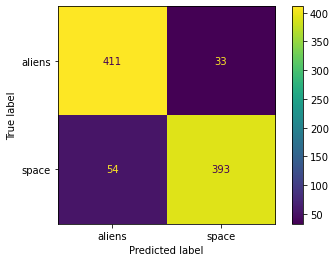

In [174]:
plot_confusion_matrix(tfidf_mb_gs, X_test, y_test)  
plt.show()

#### TFIDF RandomForest

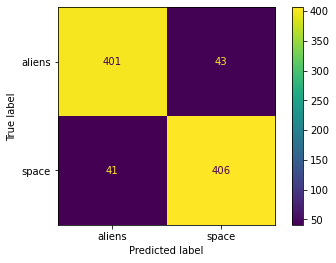

In [175]:
plot_confusion_matrix(tfidf_rf_gs, X_test, y_test)  
plt.show()

#### TFIDF CatBoost

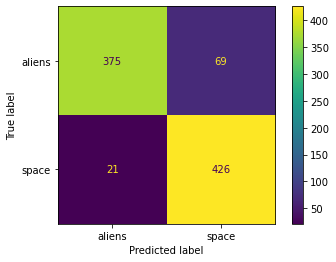

In [176]:
plot_confusion_matrix(tfidf_cat_gs, X_test, y_test)  
plt.show()

#### TFIDF LogisticRegression

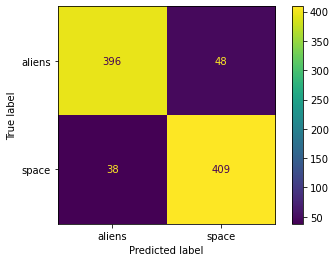

In [177]:
plot_confusion_matrix(tfidf_lr_gs, X_test, y_test)  
plt.show()

## Confusion Matrix for CVec

In [178]:
nb_pred = cvec_mb_gs.predict(X_test)
rf_pred = cvec_rf_gs.predict(X_test)
cat_pred = cvec_rf_gs.predict(X_test)
lr_pred = cvec_lr_gs.predict(X_test)

In [179]:
confusion_matrix(y_test, nb_pred)
confusion_matrix(y_test, rf_pred)
confusion_matrix(y_test, cat_pred)
confusion_matrix(y_test, lr_pred)

array([[385,  59],
       [ 24, 423]], dtype=int64)

In [180]:
nb_tn, nb_fp, nb_fn, nb_tp = confusion_matrix(y_test, nb_pred).ravel()
rf_tn, rf_fp, rf_fn, rf_tp = confusion_matrix(y_test, rf_pred).ravel()
cat_tn, cat_fp, cat_fn, cat_tp = confusion_matrix(y_test, cat_pred).ravel()
lr_tn, lr_fp, lr_fn, lr_tp = confusion_matrix(y_test, lr_pred).ravel()

## Confusion Matrix

#### CVec MultinomialNB

In [181]:
print(f"True Negatives: {nb_tn}")
print(f"False Positives: {nb_fp}")
print(f"False Negatives: {nb_fn}")
print(f"True Positives: {nb_tp}")

True Negatives: 418
False Positives: 26
False Negatives: 54
True Positives: 393


#### CVec RandomForest

In [182]:
print(f"True Negatives: {rf_tn}")
print(f"False Positives: {rf_fp}")
print(f"False Negatives: {rf_fn}")
print(f"True Positives: {rf_tp}")

True Negatives: 398
False Positives: 46
False Negatives: 38
True Positives: 409


#### CVec CatBoost

In [183]:
print(f"True Negatives: {cat_tn}")
print(f"False Positives: {cat_fp}")
print(f"False Negatives: {cat_fn}")
print(f"True Positives: {cat_tp}")

True Negatives: 398
False Positives: 46
False Negatives: 38
True Positives: 409


#### CVec LogisticRegression

In [184]:
print(f"True Negatives: {lr_tn}")
print(f"False Positives: {lr_fp}")
print(f"False Negatives: {lr_fn}")
print(f"True Positives: {lr_tp}")

True Negatives: 385
False Positives: 59
False Negatives: 24
True Positives: 423


## Classification Report

### Final scores for different models.

#### Focus was placed on Precision, F1 score for the final decision for production model.

#### Classification Report MultinomialNB

In [185]:
print(classification_report(y_test, nb_pred,target_names=my_tags))

              precision    recall  f1-score   support

      aliens       0.89      0.94      0.91       444
       space       0.94      0.88      0.91       447

    accuracy                           0.91       891
   macro avg       0.91      0.91      0.91       891
weighted avg       0.91      0.91      0.91       891



#### Classification Report RandomForest

In [186]:
print(classification_report(y_test, rf_pred,target_names=my_tags))

              precision    recall  f1-score   support

      aliens       0.91      0.90      0.90       444
       space       0.90      0.91      0.91       447

    accuracy                           0.91       891
   macro avg       0.91      0.91      0.91       891
weighted avg       0.91      0.91      0.91       891



#### Classification Report CatBoost

In [187]:
print(classification_report(y_test, cat_pred,target_names=my_tags))

              precision    recall  f1-score   support

      aliens       0.91      0.90      0.90       444
       space       0.90      0.91      0.91       447

    accuracy                           0.91       891
   macro avg       0.91      0.91      0.91       891
weighted avg       0.91      0.91      0.91       891



#### Classification Report LogisticRegression

In [188]:
print(classification_report(y_test, lr_pred,target_names=my_tags))

              precision    recall  f1-score   support

      aliens       0.94      0.87      0.90       444
       space       0.88      0.95      0.91       447

    accuracy                           0.91       891
   macro avg       0.91      0.91      0.91       891
weighted avg       0.91      0.91      0.91       891



#### How the decision on production model was reached

As our problem is a classification problem, interpretability, accuracy and F1-score will be our main metrics here.

From the table shown here, Logistic Regression had comparable F1-score of 0.91 among all the models.

Logistic regression also had the best interpretability among the models and takes up the least amount of processing power.

## Confusion Matrix Visualization

#### CVec MultinomialNB

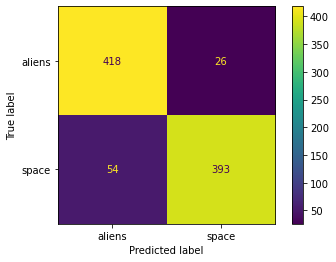

In [189]:
plot_confusion_matrix(cvec_mb_gs, X_test, y_test)  
plt.show()

#### CVec RandomForest

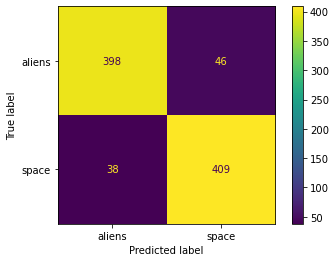

In [190]:
plot_confusion_matrix(cvec_rf_gs, X_test, y_test)  
plt.show()

#### CVec CatBoost

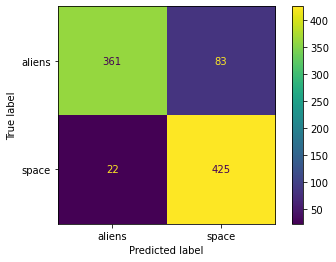

In [191]:
plot_confusion_matrix(cvec_cat_gs, X_test, y_test)  
plt.show()

#### CVec LogisticRegression

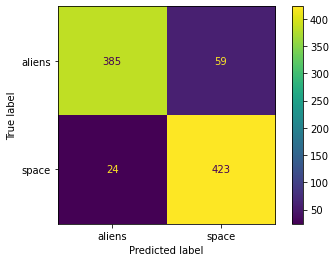

In [192]:
plot_confusion_matrix(cvec_lr_gs, X_test, y_test)  
plt.show()

## Choice of production model

The choice of production model would be MultinominalNB as it has the least false positives and comparable false negatives vs:

##### False positives:

In [193]:
print(f"Naive Bayers: {nb_fp}")
print(f"Random Forest: {rf_fp}")
print(f"Catboost: {cat_fp}")
print(f"Logistic Regression: {lr_fp}")

Naive Bayers: 26
Random Forest: 46
Catboost: 46
Logistic Regression: 59


##### False negatives:

In [194]:
print(f"Naive Bayers: {nb_fn}")
print(f"Random Forest: {rf_fn}")
print(f"Catboost: {cat_fn}")
print(f"Logistic Regression: {lr_fn}")

Naive Bayers: 54
Random Forest: 38
Catboost: 38
Logistic Regression: 24


## Model workings

#### LogisticRegression

Logistic Regression was used to classify our posts into the respective subreddits. Its algorithm allows mapping of the predicted values to probabilities through the use of a sigmoid function.

This allows the function to map the predicted value between 0 and 1.

Logistic regression has better interpretability and thus will be selected as production model.

https://towardsdatascience.com/the-perfect-recipe-for-classification-using-logistic-regression-f8648e267592

## SHAP Interpretation

Using a game theoretic approach to explain the output of the machine learning model for better interpretation.

Source: https://github.com/slundberg/shap

In [195]:
import shap
shap.initjs()

## SHAP for interpreting results of TFIDF MultinomialNB

## Best params from gridsearch will be used to fit model

In [196]:
tfidf_mb_gs.best_params_

{'mb__alpha': 1,
 'tvec__max_features': 5000,
 'tvec__ngram_range': (1, 2),
 'tvec__stop_words': None}

In [197]:
tf_par =  {
    'max_features': 1000,
    'ngram_range': (1, 2),
    'stop_words': None
          }

In [198]:
tvec = TfidfVectorizer(**tf_par)

In [199]:
X_tvec = pd.DataFrame(tvec.fit_transform(X['selftext']).todense(), 
                          columns=tvec.get_feature_names())

In [200]:
X_train, X_test, y_train, y_test = train_test_split(X_tvec, y, train_size=0.8, random_state = 42, stratify=y)

In [201]:
mb_par = {'alpha': 1}

In [202]:
tvec_mb = MultinomialNB(**mb_par)

In [203]:
tvec_mb.fit(X_train, y_train)

MultinomialNB(alpha=1)

In [204]:
tvec_mb.score(X_train, y_train)

0.9146067415730337

In [205]:
tvec_mb.score(X_test, y_test)

0.8888888888888888

In [206]:
nb_test = X_test.iloc[1]

In [207]:
nb_test_y = y_test.iloc[1]

In [208]:
nb_test_y

'aliens'

In [209]:
shap_explainer = shap.Explainer(tvec_mb, X_test)
shap_values = shap_explainer.shap_values(X_test)

## Interpretation for inferential/descriptive statistics

Looking beyond just the surface level or just the coefficients of the model, we wanted to look at global interpretability and its local interpretability.
We used SHAP - a model explainer that uses a game theory approach to explaining the model in detail - which applies to tree based models too.

SHAP summary plot was used to display 3 important information: <br>
1. Feature importance <br>
2. Impact <br>
3. Correlation <br>

Global interpretability - It allows features to be interpreted on a global level, where we are able to see not only how the feature weighs on the model, but its: <br>
Impact - determined by the X location on the scale. <br>
Correlation - whether it has a positive/negative or a mix of both correlations on the model feature. <br>

This greatly pushes our understanding of the model and allows us to understand the decision making process.


In [210]:
shap.force_plot(shap_explainer.expected_value, shap_values[1, :], nb_test)

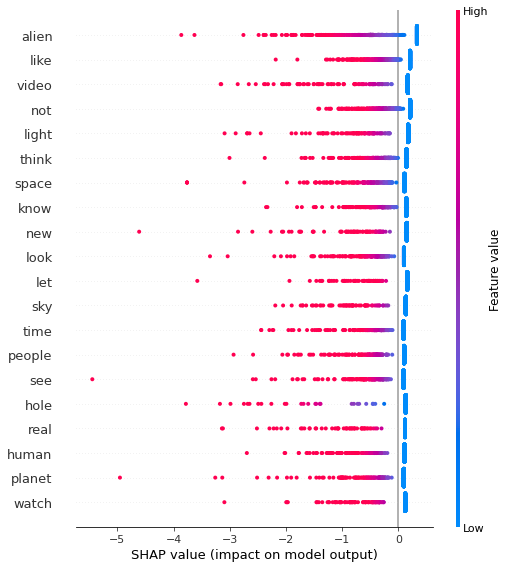

In [211]:
shap.summary_plot(shap_values, X_test)

## SHAP for interpreting results of CVec MultinomialNB

In [212]:
cvec_mb_gs.best_params_

{'cvec__max_features': 10000,
 'cvec__ngram_range': (1, 2),
 'cvec__stop_words': None,
 'mb__alpha': 1}

In [213]:
cvec_par =  {
    'max_features': 10000,
    'ngram_range': (1, 2),
    'stop_words': None
          }

In [214]:
cvec = CountVectorizer(**cvec_par)

In [215]:
X_cvec = pd.DataFrame(
    cvec.fit_transform(X['selftext']).todense(),
    columns = cvec.get_feature_names()
)

In [216]:
X_train_cvec, X_test_cvec, y_train_cvec, y_test_cvec = train_test_split(X_cvec, y, train_size=0.8, random_state = 42, stratify=y)

In [217]:
mb_par = {'alpha': 1}

In [218]:
cvec_mb = MultinomialNB(**mb_par)

In [219]:
cvec_mb.fit(X_train_cvec, y_train_cvec)

MultinomialNB(alpha=1)

In [220]:
cvec_mb.score(X_train_cvec, y_train_cvec)

0.951123595505618

In [221]:
cvec_mb.score(X_test_cvec, y_test_cvec)

0.9124579124579124

In [222]:
nb_test = X_test_cvec.iloc[1]

In [223]:
nb_test_y = y_test_cvec.iloc[1]

In [224]:
nb_test_y

'aliens'

In [225]:
shap_explainer = shap.Explainer(cvec_mb, X_test_cvec)
shap_values = shap_explainer.shap_values(X_test_cvec)

## Interpretation for inferential/descriptive statistics

In [226]:
shap.force_plot(shap_explainer.expected_value, shap_values[1, :], nb_test)

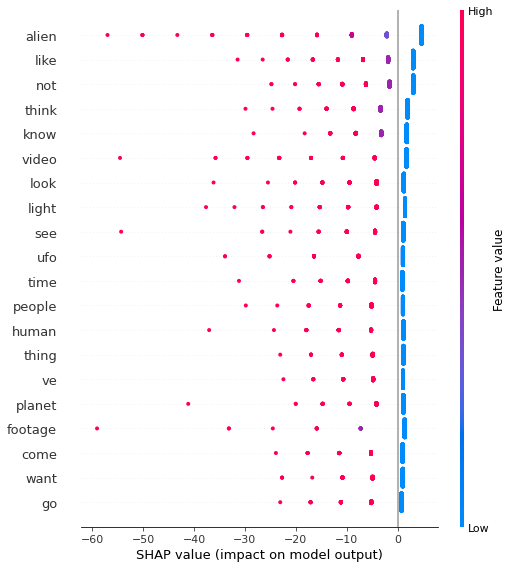

In [227]:
shap.summary_plot(shap_values, X_test_cvec)

## SHAP for interpreting results of catboost

In [228]:
cvec_cat_gs.best_params_

{'cbc__eval_metric': 'Accuracy',
 'cbc__iterations': 500,
 'cbc__l2_leaf_reg': 3.0,
 'cbc__one_hot_max_size': 2,
 'cbc__random_seed': 42,
 'cbc__random_strength': 3.0,
 'cvec__max_features': 10000,
 'cvec__ngram_range': (1, 2),
 'cvec__stop_words': None}

In [229]:
cvec_par =  {
    'max_features': 10000,
    'ngram_range': (1, 2),
    'stop_words': None
          }

In [230]:
cvec = CountVectorizer(**cvec_par)

In [231]:
X_cvec = pd.DataFrame(
    cvec.fit_transform(X['selftext']).todense(),
    columns = cvec.get_feature_names()
)

In [232]:
X_train_cvec, X_test_cvec, y_train_cvec, y_test_cvec = train_test_split(X_cvec, y, train_size=0.8, random_state = 42, stratify=y)

In [233]:
cb_par = {
 'eval_metric': 'Accuracy',
 'iterations': 500,
 'l2_leaf_reg': 3.0,
 'one_hot_max_size': 2,
 'random_seed': 42,
 'random_strength': 3.0}

In [234]:
cvec_cbc = CatBoostClassifier(**cb_par)

In [235]:
cvec_cbc.fit(X_train_cvec, y_train_cvec)

0:	learn: 0.7455056	total: 20ms	remaining: 10s
1:	learn: 0.7474719	total: 38.6ms	remaining: 9.62s
2:	learn: 0.7485955	total: 57ms	remaining: 9.44s
3:	learn: 0.7477528	total: 75.7ms	remaining: 9.38s
4:	learn: 0.7988764	total: 94.6ms	remaining: 9.37s
5:	learn: 0.7991573	total: 114ms	remaining: 9.42s
6:	learn: 0.7977528	total: 133ms	remaining: 9.39s
7:	learn: 0.7977528	total: 152ms	remaining: 9.32s
8:	learn: 0.7977528	total: 170ms	remaining: 9.27s
9:	learn: 0.7977528	total: 189ms	remaining: 9.27s
10:	learn: 0.7977528	total: 208ms	remaining: 9.24s
11:	learn: 0.7977528	total: 229ms	remaining: 9.31s
12:	learn: 0.7977528	total: 248ms	remaining: 9.28s
13:	learn: 0.7977528	total: 266ms	remaining: 9.25s
14:	learn: 0.7977528	total: 286ms	remaining: 9.24s
15:	learn: 0.7977528	total: 305ms	remaining: 9.24s
16:	learn: 0.7977528	total: 324ms	remaining: 9.21s
17:	learn: 0.7977528	total: 343ms	remaining: 9.18s
18:	learn: 0.7977528	total: 362ms	remaining: 9.16s
19:	learn: 0.7977528	total: 382ms	remainin

162:	learn: 0.8682584	total: 3.17s	remaining: 6.56s
163:	learn: 0.8676966	total: 3.19s	remaining: 6.54s
164:	learn: 0.8679775	total: 3.21s	remaining: 6.52s
165:	learn: 0.8685393	total: 3.23s	remaining: 6.5s
166:	learn: 0.8682584	total: 3.25s	remaining: 6.47s
167:	learn: 0.8688202	total: 3.27s	remaining: 6.46s
168:	learn: 0.8685393	total: 3.29s	remaining: 6.43s
169:	learn: 0.8702247	total: 3.3s	remaining: 6.41s
170:	learn: 0.8705056	total: 3.33s	remaining: 6.41s
171:	learn: 0.8707865	total: 3.35s	remaining: 6.38s
172:	learn: 0.8705056	total: 3.37s	remaining: 6.36s
173:	learn: 0.8713483	total: 3.39s	remaining: 6.35s
174:	learn: 0.8713483	total: 3.41s	remaining: 6.33s
175:	learn: 0.8716292	total: 3.43s	remaining: 6.31s
176:	learn: 0.8719101	total: 3.45s	remaining: 6.29s
177:	learn: 0.8716292	total: 3.46s	remaining: 6.27s
178:	learn: 0.8716292	total: 3.48s	remaining: 6.25s
179:	learn: 0.8719101	total: 3.5s	remaining: 6.23s
180:	learn: 0.8716292	total: 3.52s	remaining: 6.21s
181:	learn: 0.8

323:	learn: 0.9047753	total: 6.33s	remaining: 3.44s
324:	learn: 0.9044944	total: 6.35s	remaining: 3.42s
325:	learn: 0.9053371	total: 6.37s	remaining: 3.4s
326:	learn: 0.9056180	total: 6.39s	remaining: 3.38s
327:	learn: 0.9061798	total: 6.41s	remaining: 3.36s
328:	learn: 0.9064607	total: 6.43s	remaining: 3.34s
329:	learn: 0.9058989	total: 6.45s	remaining: 3.32s
330:	learn: 0.9058989	total: 6.47s	remaining: 3.3s
331:	learn: 0.9064607	total: 6.49s	remaining: 3.28s
332:	learn: 0.9058989	total: 6.51s	remaining: 3.26s
333:	learn: 0.9058989	total: 6.53s	remaining: 3.25s
334:	learn: 0.9064607	total: 6.55s	remaining: 3.23s
335:	learn: 0.9067416	total: 6.57s	remaining: 3.21s
336:	learn: 0.9067416	total: 6.59s	remaining: 3.19s
337:	learn: 0.9073034	total: 6.61s	remaining: 3.17s
338:	learn: 0.9073034	total: 6.63s	remaining: 3.15s
339:	learn: 0.9078652	total: 6.64s	remaining: 3.13s
340:	learn: 0.9081461	total: 6.66s	remaining: 3.11s
341:	learn: 0.9084270	total: 6.68s	remaining: 3.09s
342:	learn: 0.

486:	learn: 0.9320225	total: 9.49s	remaining: 253ms
487:	learn: 0.9323034	total: 9.51s	remaining: 234ms
488:	learn: 0.9328652	total: 9.53s	remaining: 214ms
489:	learn: 0.9328652	total: 9.55s	remaining: 195ms
490:	learn: 0.9328652	total: 9.56s	remaining: 175ms
491:	learn: 0.9331461	total: 9.58s	remaining: 156ms
492:	learn: 0.9331461	total: 9.6s	remaining: 136ms
493:	learn: 0.9331461	total: 9.62s	remaining: 117ms
494:	learn: 0.9334270	total: 9.64s	remaining: 97.4ms
495:	learn: 0.9337079	total: 9.66s	remaining: 77.9ms
496:	learn: 0.9337079	total: 9.68s	remaining: 58.4ms
497:	learn: 0.9331461	total: 9.7s	remaining: 39ms
498:	learn: 0.9331461	total: 9.72s	remaining: 19.5ms
499:	learn: 0.9334270	total: 9.74s	remaining: 0us


In [236]:
cvec_cbc.score(X_train_cvec, y_train_cvec)

0.9334269662921348

In [237]:
cvec_cbc.score(X_test_cvec, y_test_cvec)

0.8855218855218855

In [238]:
cb_test = X_test_cvec.iloc[1]

In [239]:
cb_test_y = y_test_cvec.iloc[1]

In [240]:
cb_test_y

'aliens'

In [241]:
shap_explainer = shap.TreeExplainer(cvec_cbc)
shap_values = shap_explainer.shap_values(X_test_cvec)

## Interpretation for inferential/descriptive statistics

In [242]:
shap.force_plot(shap_explainer.expected_value, shap_values[1, :], cb_test)

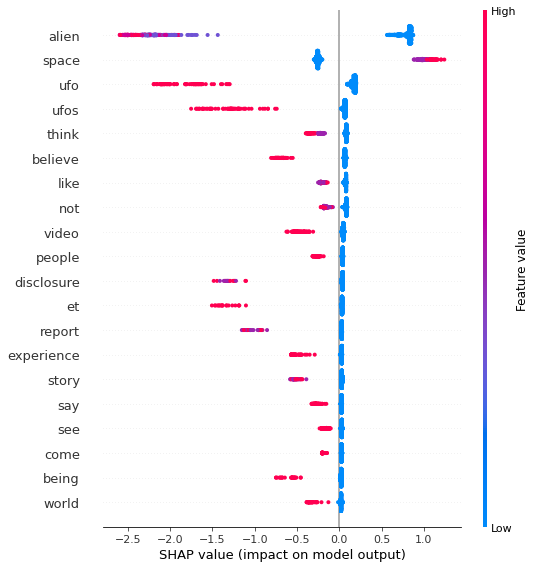

In [243]:
shap.summary_plot(shap_values, X_test_cvec)

## SHAP summary plot - Catboost

From the summary plot, we can conclude that the top words for classifying the model as "Aliens" were:

1. "Aliens"
2. "UFO"
3. "et"
4. "experience"
5. "story"


From the summary plot, we can conclude that the top words for classifying the model as "Space" were:

1. "space"
2. "universe"
3. "question"
4. "telescope"
5. "launch"

From the summary plot, we can conclude that there are a few words that might have caused the classification to be incorrect:

1. "alien" seems to have appeared in both aliens and space subreddits
2. "space seems to have appeared in both aliens and space subreddits
3. "universe" is a close classification for both subreddits
4. "planet" is a close classification for both subreddits

## SHAP for interpreting results of LogisticRegression

In [244]:
tfidf_lr_gs.best_params_

{'lr__C': 4.281332398719396,
 'lr__penalty': 'l2',
 'lr__solver': 'liblinear',
 'tvec__max_features': 5000,
 'tvec__ngram_range': (1, 1),
 'tvec__stop_words': None}

In [245]:
tf_par =  {
    'max_features': 10000,
    'ngram_range': (1, 2),
    'stop_words': 'english'
          }

In [246]:
tvec = TfidfVectorizer(**tf_par)

In [247]:
X_tvec = pd.DataFrame(tvec.fit_transform(X['selftext']).todense(), 
                          columns=tvec.get_feature_names())

In [248]:
X_train_tvec, X_test_tvec, y_train_tvec, y_test_tvec = train_test_split(X_tvec, y, train_size=0.8, random_state = 42, stratify=y)

In [249]:
lr_par = {
 'C': 4.281332398719396,
 'penalty': 'l2',
 'solver': 'liblinear'}

In [250]:
tvec_lr = LogisticRegression(**lr_par)

In [251]:
tvec_lr.fit(X_train_tvec, y_train_tvec)

LogisticRegression(C=4.281332398719396, solver='liblinear')

In [252]:
tvec_lr.score(X_train_tvec, y_train_tvec)

0.9817415730337079

In [253]:
tvec_lr.score(X_test_tvec, y_test_tvec)

0.920314253647587

In [254]:
lr_test = X_test_tvec.iloc[1]

In [255]:
pd.DataFrame(lr_test).T

,07,10,10 15,10 km,10 million,10 minute,10 pm,10 second,10 time,10 year,...,zip,zodiac,zohar,zohar star,zone,zoo,zoom,zoom adapter,zoom sky,zubrin
190,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [256]:
lr_test_y = y_test_tvec.iloc[1]

In [257]:
lr_test_y

'aliens'

In [258]:
shap_explainer = shap.Explainer(tvec_lr, X_test_tvec)
shap_values = shap_explainer.shap_values(X_test_tvec)

## Interpretation for inferential/descriptive statistics

In [259]:
shap.force_plot(shap_explainer.expected_value, shap_values[1, :], lr_test)

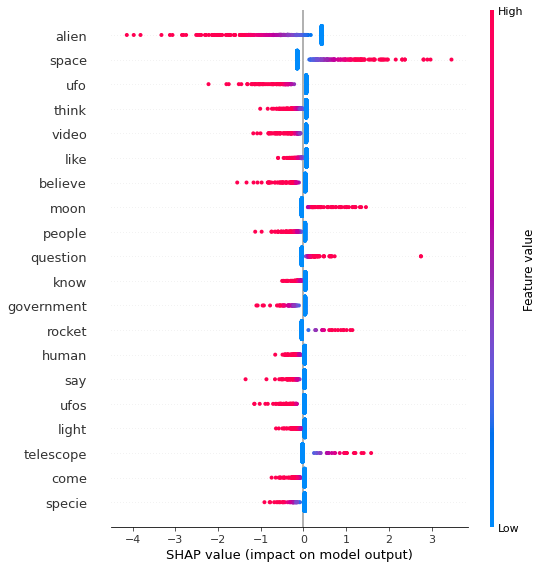

In [260]:
shap.summary_plot(shap_values, X_test_tvec)

## SHAP summary plot - Logistic Regression

From the summary plot, we can conclude that the top words for classifying the model as "Aliens" were:

1. "aliens"
2. "believe"
3. "ufo"
4. "theory"
5. "disclosure"


From the summary plot, we can conclude that the top words for classifying the model as "Space" were:

1. "space"
2. "universe"
3. "mar"
4. "question"
5. "moon"

From the summary plot, we can conclude that there are a few words that might have caused the classification to be incorrect:

1. "alien" seems to have appeared in both aliens and space subreddits
2. "space" seems to have appeared in both aliens and space subreddits
3. "universe" is a close classification for both subreddits
4. "question" is a close classification for both subreddits

### ROC Curve

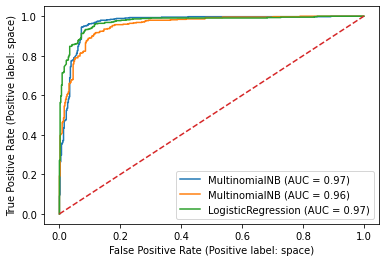

In [261]:
cvec_mb_disp = plot_roc_curve(cvec_mb, X_test_cvec, y_test)
tvec_mb_disp = plot_roc_curve(tvec_mb, X_test, y_test, ax = cvec_mb_disp.ax_)
tvec_lr_disp = plot_roc_curve(tvec_lr, X_test_tvec, y_test_tvec, ax = tvec_mb_disp.ax_)
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--') 
plt.show();

Among the models, logistic regression had borderline better results and had a slightly higher gradient. It had a comparable AUC compared to other models signalling better degree of separability.

## Context to connect individual steps back to overall project

1. Outliers and short posts of less than 3 were removed as they often contained links and pictures.
2. Using both TFIDF and CVec, data was modeled using 4 different classification techniques: <br>
    a. MultinominalNB <br>
    b. RandomForest Classifier <br>
    c. CatboostClassifier <br>
    d. LogisticRegression <br>
3. As test dataset scores does not mean much for accuracy, confusion matrix were plotted for each model.
4. Accuracy, F1 scores became the focus point and benchmark for the models as they represent accurate classification
5. SHAP - using a game theoretic approach to explain the output of the selected production model was used as they have 2 important plots.
    a. Force plot - Represents the "force" each classification word contributed to the classification decision making process.
    b. Summary plot - Summarizes and shows how each word affected the decision making, and displays words that were close to boundaries of the decision making process.

source: https://github.com/slundberg/shap

## Final recommendations

#### How the conclusions were reached

The model conclusion were made based on: <br>
    1. Accuracy <br>
    2. Interpretability <br>
    3. Processing speed <br>
    
Among the models, the accuracy were fairly close representing close percentages within each other.

3 main scores for accuracy were considered:
1. Accuracy
2. Precision
3. F1 score

F1 score provides a balance between precision and recall and would be suitable for this application.

However, the randomforest and catboost traded off processing power and time to achieve a similar score as logisticregression.

Similarly, during model interpretation, randomforest took the longest time to run SHAP and likely needed a GPU to complete the step within a reasonable amount of time.

Hence, in terms of the 3 metrics defined above, logisticregression which did not have the best accuracy, had considerably better interpretability and processing speed which was important for future use.

Furthermore, its score was not far off from the best accuracy scoring model.

It can be concluded that LogisticRegression classification method was the most desirable among all the other models.

#### Stating the conclusions/recommendations clearly

Conclusions:
Selected model was TFIDF Logistic Regression

With the selected model, it can be seen that the posts can be predicted with a good accuracy.

Words such as "Aliens", "Space", "Universe", "ET" were good predictors of its subreddit classifications.

#### Answering the problem statement

Recapping the problem statement where the main goal was to classify the reddit posts accurately to benefit our primary and secondary stakeholders for the sake of posts monitoring, media and marketing efforts.

The model was successfully built to handle the requests for MIB and classify the reddit posts according to its subreddits.

#### Applying findings of research for benefit of stakeholders

For the benefit of stakeholders, there were a few words that the stakeholders needed to take note of as these words appeared to be very strong indicators of classification as can be seen from the SHAP model interpretation.

"Aliens", "Space", "Universe", "Telescopes", "ET"

These were strong predictors of the respective subreddits and hence should be taken note of for any future work.

## Future steps to move the project forward

1. Sentiment Analysis
2. Topic modelling using BERT, Latent Dirichlet Allocation

Sentiment analysis helps our primary and secondary stakeholders by providing them with necessary information on how citizens think about Aliens and Space.

This will give MIB and media groups (secondary stakeholders) useful information of citizen's sentiments before they publish or market any information or products.

Topic modelling is another important area to look into as topic modelling is an unsupervised learning method to inform the primary and secondary stakeholders on the topics discussed through reddits.

By understanding the topics discussed, it gives MIB and media groups control and understanding over whether any undesirable topics were being discussed.

Being unsupervised, it allows the model to understand any changing topics discussed and allows MIB to take swift action if necessary.

Sources: <br>

https://medium.com/@akankshamalhotra24/introduction-to-libraries-of-nlp-in-python-nltk-vs-spacy-42d7b2f128f2

https://christophm.github.io/interpretable-ml-book/shapley.html

https://proceedings.neurips.cc/paper/2017/hash/8a20a8621978632d76c43dfd28b67767-Abstract.html

https://github.com/slundberg/shap